In [1]:
import os
import astropy
import requests
import pandas as pd
import numpy as np
import lightkurve as lk 
from scipy.interpolate import interp1d
from astropy.modeling import models, fitting
import matplotlib.pyplot as plt
import emcee
import sys
import csv
from astropy.timeseries import LombScargle
from os.path import basename, exists

# change these paths to wherever you have the files
# sys.path.insert(1,'/Users/neisner/Documents/code/utils/')
import filters # Suzanne's functions
import norm

# change these paths to wherever you have the files
# sys.path.insert(1,'/Users/neisner/Documents/code/ETV')
import etv_functions # Nora's functions 

%matplotlib inline

In [2]:
from IPython.display import display, HTML, Javascript, clear_output

display(HTML("<style>.container { width:99% !important; }</style>"))  # Jupyter 6
display(HTML("<style>.jp-Notebook { --jp-notebook-max-width: 98%; }</style>"))  # Jupyter 7

# define the paths where the data will be stores - NEED TO CHANGE THIS TO YOUR OWN PATH
outfile_base = './etv_out'  # for ETV
lk_download_dir = 'C:/dev/_juypter/PH_TESS_LightCurveViewer/data'  

# A command from shell that can be run to notify users, e.g., fitting is finished. Use "echo" if you do not have one
NOTIFY_CMD = "win-notify.bat"

if hasattr(lk, "conf"):  # default download dir
    lk.conf.cache_dir = lk_download_dir
if hasattr(lk.search, "sr_cache"):   # PR for persistent query result cache
    lk.search.sr_cache.cache_dir = lk_download_dir  # None
    lk.search.sr_cache.expire_second = 86400

## Looking for ETVs in TIC 273874851


In [3]:
# define the plotting parameters

figsize = (8,4)

In [8]:
# import the data

# choose a TIC ID to analyze
ticid = 273874851  # EW, only 2 sectors of 2min data

# define the paths where the data will be stores - NEED TO CHANGE THIS TO YOUR OWN PATH
outfile_path = f"{outfile_base}/tic{ticid}_etv_primary.csv"
outfile_path_s = f"{outfile_base}/tic{ticid}_etv_secondary.csv"


# import data using Lightkurve
# sr = lk.search_lightcurve('TIC {}'.format(ticid), author = 'SPOC')  
if not "../.." in sys.path:
    sys.path.append("../..")
import lightkurve_ext as lke  # at ../../
import astropy.units as u


sr = lk.search_lightcurve('TIC {}'.format(ticid))  # get long cadence data too
sr = lke.filter_by_priority(sr, author_priority=['SPOC', 'TESS-SPOC'], exptime_priority=['short', 'long', 'fast'])
# sr = sr[sr.exptime != 1800 *u.s]  # exclude 30min cadence data for now (TESS-SPOC, sectors 18, 19, 23 )
# sr = sr[np.isin(sr.author, ['SPOC', 'TESS-SPOC'])]  # exclude QLP to ensure for uniformity in the data
sr = lke._sort_chronologically(sr)  # workaround lightkurve v2.4.2+ change in sort order
display(sr)
lcc_tess = sr.download_all()
lc_tess = lcc_tess.stitch()
# lc_tess = lc_tess.truncate(None, 1450)  # use data from sectors 2 - 3 for now


search_result = lc_tess

time = search_result.time.value
flux = search_result.flux.value
fluxerr = search_result.flux_err.value
len(search_result)

SearchResult containing 5 data products.

 #     mission     year author exptime target_name distance proposal_id
                                  s                 arcsec             
--- -------------- ---- ------ ------- ----------- -------- -----------
  0 TESS Sector 14 2019   SPOC     120   273874851      0.0     G022062
  1 TESS Sector 15 2019   SPOC     120   273874851      0.0     G022062
  2 TESS Sector 41 2021   SPOC     120   273874851      0.0      G04171
  3 TESS Sector 54 2022   SPOC     120   273874851      0.0      G04171
  4 TESS Sector 56 2022   SPOC     120   273874851      0.0      G05003

92006

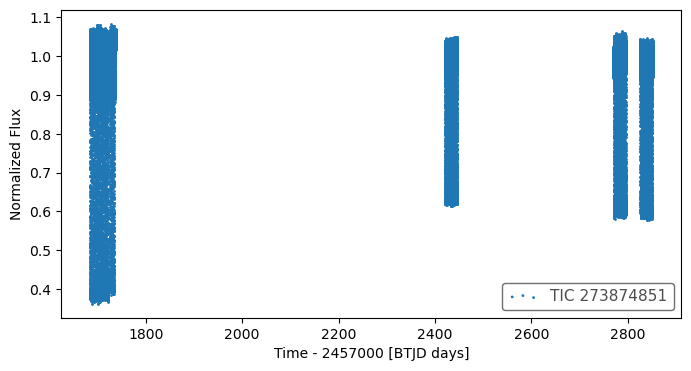

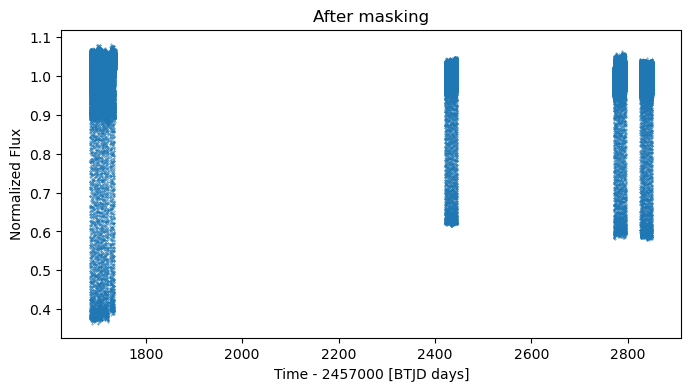

In [5]:
%matplotlib inline
# %matplotlib widget

time = search_result.time.value
flux = search_result.flux.value
fluxerr = search_result.flux_err.value
len(search_result)

# mask out data you don't like...

fig, ax = plt.subplots(figsize=figsize)
search_result.scatter(ax = ax)

mask = time < 0  #( time > 54950) & (time < 54963)  #  truncate weird spikes at the beginning of Kepler data  
# mask = flux < 0.85    # remove occassional outliers

time = time[~mask]
flux = flux[~mask]
fluxerr = fluxerr[~mask]

# make sure that therte are no nans!

finite_mask = np.isfinite(time) * np.isfinite(flux) * np.isfinite(fluxerr)

# make a dictionary of the data 

data = pd.DataFrame({'time': time[finite_mask], 'flux': flux[finite_mask], 'err': fluxerr[finite_mask]})

ax2 = plt.figure(figsize=figsize).gca()
ax2.scatter(data.time, data.flux, s=0.1);
ax2.set_ylabel(ax.get_ylabel())
ax2.set_xlabel(ax.get_xlabel())
ax2.set_title("After masking");

In [ ]:
do_bls = False

if do_bls:
    if not "../.." in sys.path:
        sys.path.append("../..")
    import lightkurve_ext_pg_runner as lke_pg_runner  # at ../../

    bls_result = lke_pg_runner.run_bls(
        search_result.remove_nans(),
        pg_kwargs=dict(
            minimum_period=1, maximum_period=20,
            frequency_factor=1,            
            duration=[3.4957 / 24 * f for f in [0.975, 1, 1.025, 1.05, 1.1, 1.15,]],  # based on observed primary eclipse duration for better fit
        ),
    )
    !$NOTIFY_CMD  "BLS Done"

In [ ]:
# Visaully compare different candidate period

# ax = search_result.normalize().fold(epoch_time=1471.4196, period=8.418132651611877).truncate(-0.1, 0.1).scatter(label="BLS period, frequency_factor=10");  # HWHM 0.001571020094789155
# ax = search_result.normalize().fold(epoch_time=1471.4196, period=8.418147).truncate(-0.1, 0.1).scatter(label="s0001-s0009:TCE1");

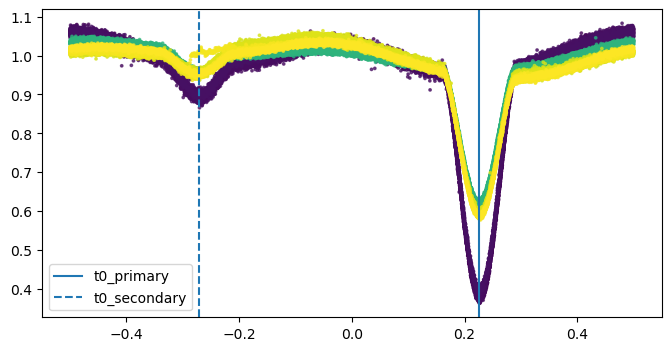

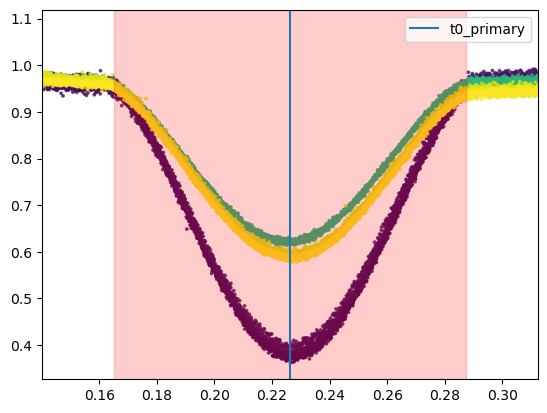

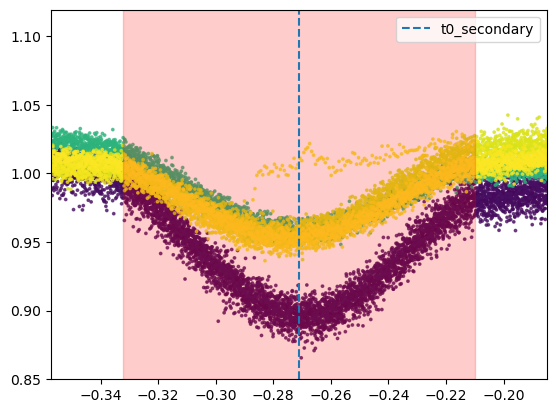

In [48]:
%matplotlib inline
# %matplotlib widget

from astropy.time import Time

# define the orbital period and the t0 

# epoch=1683.4692, duration_hr=3.5000, period=2.045219, label="s0014-s0060:TCE1",
# TCE2 exists, but it matches a bogus dip
# VSX: 2.04516121
# MCMC on df_primary: 2.045206282737052

# FILL-IN THE eclipse epoch / period, 
period = 2.045206  # MCMC

t0_primary = 1683.4692 + 0.01  # offsets applied after visual inspection
t0_secondary = t0_primary +  1.028  # from TCE1


# convert epoch from BTJD to commonly mjd used here
# t0_primary = Time(t0_primary, format="btjd").to_value("mjd")
# t0_secondary = Time(t0_secondary, format="btjd").to_value("mjd")

# Move t0 to the first dip in the data (some of the subsequent codes, espically fit_each_eclipse(), assumes that)
t0_primary = t0_primary - int((t0_primary - data['time'][0]) / period) * period
if t0_secondary is not None:
    t0_secondary = t0_secondary - int((t0_secondary - data['time'][0]) / period) * period

duration_hr_primary = 6
duration_hr_secondary = 6

# t0_for_plotting = 0  # keep 0 for plotting purposes
t0_for_plotting = t0_primary - np.abs(t0_primary - t0_secondary) * 0.45  # use a custom one so that the eclipses are not near the edge (-0.5 or +0.5)

phase = etv_functions.phase_data(data['time'], t0_for_plotting, period)

fig, ax = plt.subplots(figsize = (8,4))

plt.scatter(phase,data['flux'], s = 3, alpha = 0.7, c = data['time'])

# add the phase to the dataframe
data['phase'] = phase

plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
if t0_secondary is not None:
    plt.axvline(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0], linestyle="--", label="t0_secondary")
plt.legend()
# plt.ylim(0.535, 0.55)
# plt.xlim(-0.5, 0.1)
plt.show();

plt.scatter(phase,data['flux'], s = 3, alpha = 0.7, c = data['time'])
plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
t1_p, t4_p = etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] - 0.5 * duration_hr_primary / 24/ period, etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] + 0.5 * duration_hr_primary / 24/ period 
plt.xlim(t1_p - 0.025, t4_p + 0.025);
plt.axvspan(t1_p, t4_p, color="red", alpha=0.2);plt.legend();
# plt.ylim(0.75, 0.85);
plt.show()

plt.scatter(phase,data['flux'], s = 3, alpha = 0.7, c = data['time'])
plt.axvline(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0], linestyle="--", label="t0_secondary")
t1_s, t4_s = etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] - 0.5 * duration_hr_secondary / 24/ period, etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] + 0.5 * duration_hr_secondary / 24/ period 
plt.xlim(t1_s - 0.025, t4_s + 0.025);
plt.axvspan(t1_s, t4_s, color="red", alpha=0.2);plt.legend();
plt.legend();
plt.ylim(0.85, None);
plt.show()

### Compare folded plots across sectors

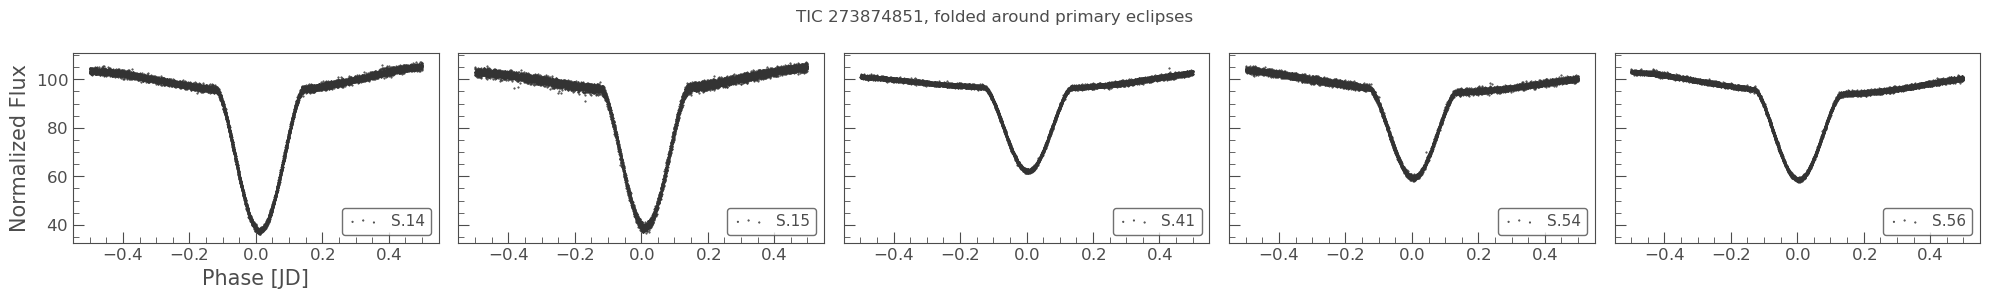

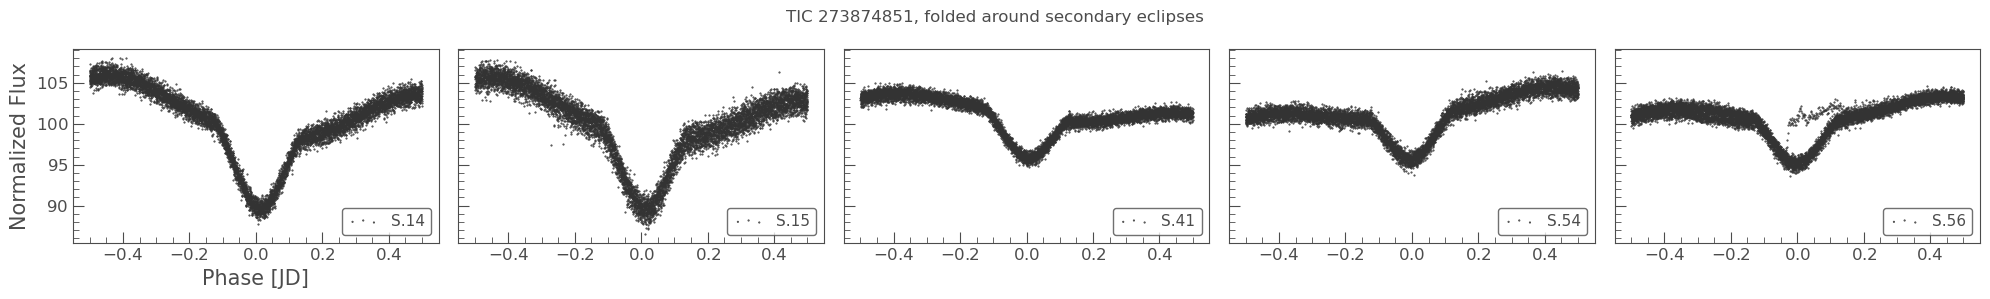

In [23]:
with plt.style.context(lk.MPLSTYLE):
    fig, axs = plt.subplots(1, len(lcc_tess), figsize=(4 * len(lcc_tess), 3), sharey=True);
    if isinstance(axs, plt.Axes):
        axs = [axs]
    for i, lc in enumerate(lcc_tess):
        lc_f = lc.select_flux("flux").normalize(unit="percent").fold(period=period, epoch_time=t0_primary)
        lc_f = lc_f.truncate(-duration_hr_primary * 2 / 24, duration_hr_primary * 2 / 24)
        ax = lc_f.scatter(ax=axs[i], s=1, label=f"S.{lc_f.sector}");
        ax.legend(loc="lower right");
        if i > 0: 
            ax.set_ylabel(None)
            ax.set_xlabel(None)
    fig.suptitle(f"{lc.label}, folded around primary eclipses");
plt.tight_layout();

# ---
with plt.style.context(lk.MPLSTYLE):
    fig, axs = plt.subplots(1, len(lcc_tess), figsize=(4 * len(lcc_tess), 3), sharey=True);
    if isinstance(axs, plt.Axes):
        axs = [axs]
    for i, lc in enumerate(lcc_tess):
        lc_f = lc.select_flux("flux").normalize(unit="percent").fold(period=period, epoch_time=t0_secondary)
        lc_f = lc_f.truncate(-duration_hr_secondary * 2 / 24, duration_hr_secondary * 2 / 24)
        ax = lc_f.scatter(ax=axs[i], s=1, label=f"S.{lc_f.sector}");
        ax.legend(loc="lower right");
        if i > 0: 
            ax.set_ylabel(None)
            ax.set_xlabel(None)
    fig.suptitle(f"{lc.label}, folded around secondary eclipses");
plt.tight_layout();

### Detrend (optional)

- detrended flux is in `flux_detrended`, and won't be used in subsequent work by default

In [ ]:
# show data to visualize what's changed in each step below
data  

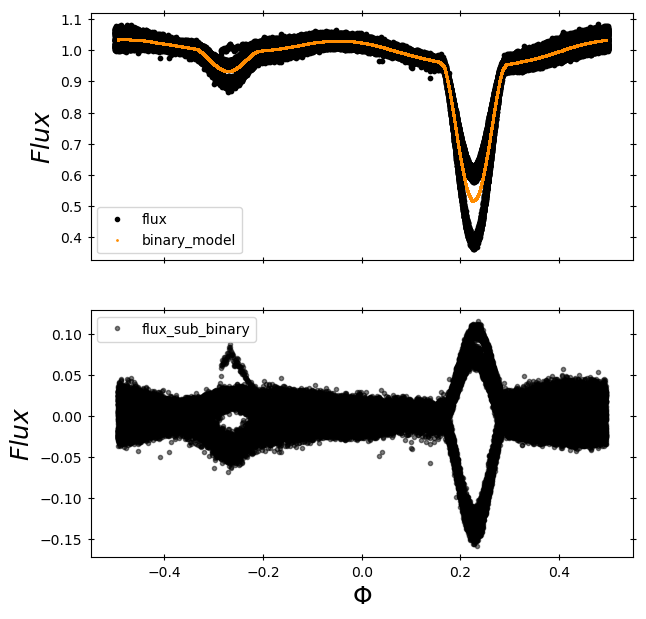

time      flux       err     phase  flux_sub_binary  \
0      1683.356027  0.961519  0.006023  0.165962         0.012214   
1      1683.357416  0.954533  0.006014  0.166642         0.007644   
2      1683.358805  0.945461  0.006006  0.167321         0.001476   
3      1683.360194  0.940828  0.006002  0.168000         0.000186   
4      1683.361583  0.934299  0.006009  0.168679        -0.002610   
...            ...       ...       ...       ...              ...   
90690  2853.134193  0.971119  0.003373  0.127010        -0.002149   
90691  2853.135582  0.965705  0.003374  0.127689        -0.007350   
90692  2853.136971  0.971665  0.003375  0.128368        -0.001181   
90693  2853.138359  0.972272  0.003376  0.129047        -0.000368   
90694  2853.139748  0.966211  0.003370  0.129726        -0.006225   

       binary_model  
0          0.949305  
1          0.946890  
2          0.943985  
3          0.940641  
4          0.936909  
...             ...  
90690      0.973269  
90691      0.973055  
90692      0.972846  
90693      0.972640  
90694      0.972436  

[90695 rows x 6 columns]

In [108]:
# phase fold the data and create an appoximate binary model (top) and subtract it from the data (bottom)
#_, _ , flux_sub_binary, model, _, _ = etv_functions.trend_removal_interact(period, 0, data['time'], data['flux'], data['time'], data['flux'])

data = etv_functions.trend_removal_interact(period, t0_for_plotting, data)
data

10 89750 901
reached the end
10 82627 901
reached the end
10 81194 901
reached the end
10 80892 901
reached the end
10 80825 901
reached the end


time      flux       err     phase  flux_sub_binary  \
0      1683.356027  0.961519  0.006023  0.165962         0.012214   
1      1683.357416  0.954533  0.006014  0.166642         0.007644   
2      1683.358805  0.945461  0.006006  0.167321         0.001476   
3      1683.360194  0.940828  0.006002  0.168000         0.000186   
4      1683.361583  0.934299  0.006009  0.168679        -0.002610   
...            ...       ...       ...       ...              ...   
90690  2853.134193  0.971119  0.003373  0.127010        -0.002149   
90691  2853.135582  0.965705  0.003374  0.127689        -0.007350   
90692  2853.136971  0.971665  0.003375  0.128368        -0.001181   
90693  2853.138359  0.972272  0.003376  0.129047        -0.000368   
90694  2853.139748  0.966211  0.003370  0.129726        -0.006225   

       binary_model  flux_detrended  
0          0.949305        0.959428  
1          0.946890        0.952328  
2          0.943985        0.943138  
3          0.940641        0.938389  
4          0.936909        0.931746  
...             ...             ...  
90690      0.973269        0.972160  
90691      0.973055        0.966759  
90692      0.972846        0.972732  
90693      0.972640        0.973351  
90694      0.972436        0.967302  

[90695 rows x 7 columns]

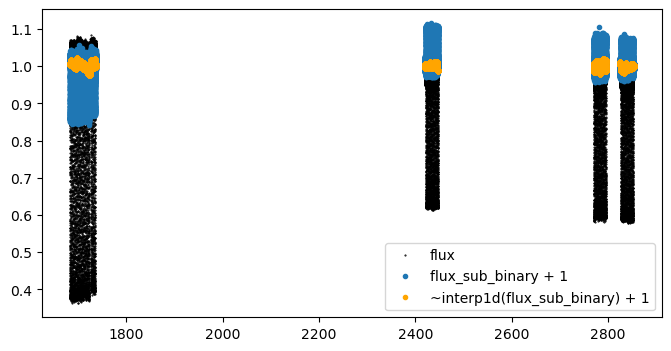

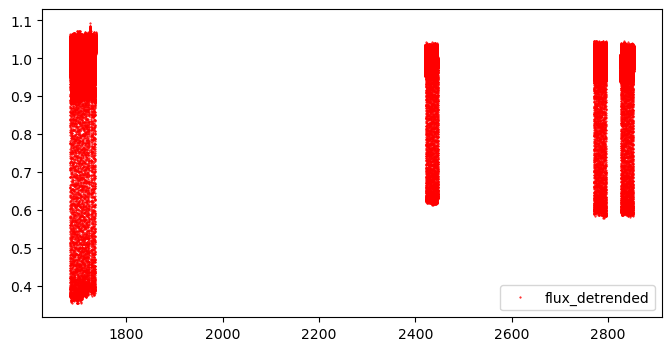

In [109]:
# if you want to detrend the data run this line!

data = etv_functions.detrend_suz(data, T_dur = 10, plot = True)
data

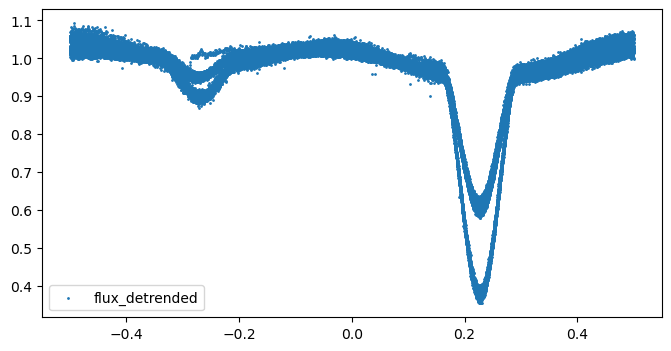

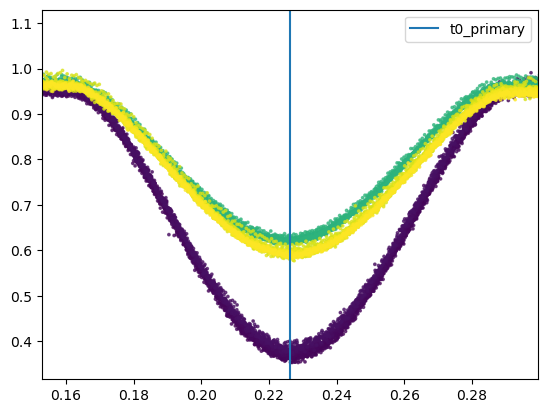

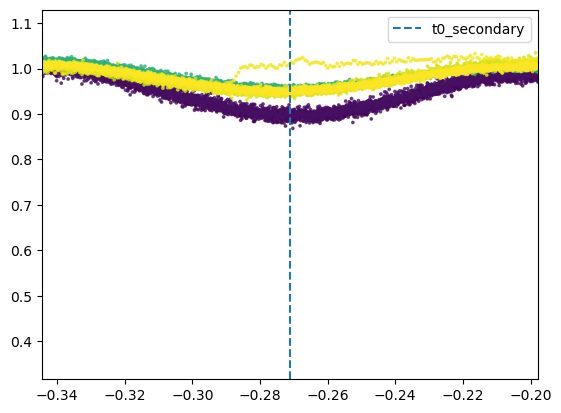

In [110]:
# plot the phase folded data here so that you know at what phase you want to cut the data to model 
fig, ax = plt.subplots(figsize = figsize)
plt.scatter(data.phase, data.flux_detrended, s = 1, label="flux_detrended")
plt.legend()
plt.show()

plt.scatter(phase,data['flux_detrended'], s = 3, alpha = 0.7, c = data['time'])
plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
plt.xlim(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] - 0.6 * duration_hr_primary / 24/ period, etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] + 0.6 * duration_hr_primary / 24/ period);
plt.legend();
# plt.ylim(0.75, 0.85);
plt.show()

plt.scatter(phase,data['flux_detrended'], s = 3, alpha = 0.7, c = data['time'])
plt.axvline(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0], linestyle="--", label="t0_secondary")
plt.xlim(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] - 0.6 * duration_hr_secondary / 24/ period, etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] + 0.6 * duration_hr_secondary / 24/ period);
plt.legend();
# plt.ylim(0.75, 0.85);
plt.show()

<span style="background-color: rgba(255, 0, 0, 0.6);"> NOTE: </span> The zoom windows below for the eclipses are made **smaller**, an attempt to reduce the complications of EW variability outside the minima (and some assymetery)

### Now that the data is ready we can start 

Primary:   1683.4792 0.22618748429256808
window_width_p (phase): 0.14668449046208548
Secondary: 1684.5072 -0.27117366172400925
window_width_s (phase): 0.14668449046208548


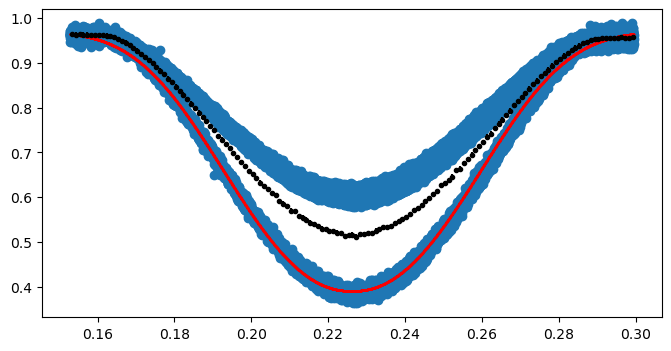

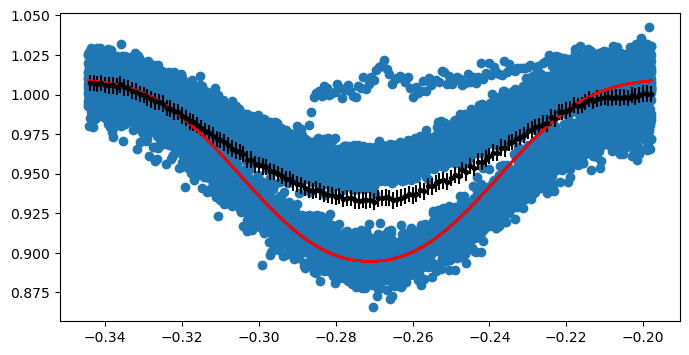

In [62]:
# define the midpoints of the primary and secondary eclipses and the window width

# if these don't look central - change them!! the eclipses should be central
midpoint_p =  etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0]  # convet to time in phase
# midpoint_p -= 0.004  # the offset is added back to t0_primary (& secondary above
print('Primary:  ', t0_primary, midpoint_p)

# change depending on the width of the eclipses, default to be slightly larger than the primary eclipse
window_width_p = 1.2 * duration_hr_primary / 24 / period   # it seems to be difficult to bit model the flat bottom and the curves outside, focus on the overall shape for now
# use a shoter duration to avoid fitting the out-of-eclipse LC, which has its own variability that the model is not equipped to hanlde
# window_width_p = 0.095
print("window_width_p (phase):", window_width_p)

data_primary = data[(data['phase'] > midpoint_p - window_width_p / 2) & (data['phase'] < midpoint_p + window_width_p / 2) ]
ph_binned,flux_binned,err_binned = etv_functions.run_binning_phased(data_primary.phase, data_primary.flux, yerr=data_primary.err,nbins=1000)


if t0_secondary is not None:
    midpoint_s =  etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0]
    print('Secondary:', t0_secondary, midpoint_s)

    # the coshgauss model seems problematic, try to use a larger width to give it more shape to fit
    window_width_s = 1.2 * duration_hr_secondary / 24 / period  
    # window_width_s = 0.22
    print("window_width_s (phase):", window_width_s)
    
    data_secondary = data[(data['phase'] > midpoint_s - window_width_s / 2) & (data['phase'] < midpoint_s + window_width_s / 2) ]
    ph_binned_s,flux_binned_s,err_binned_s = etv_functions.run_binning_phased(data_secondary.phase, data_secondary.flux, yerr=data_secondary.err,nbins=1000)


### # you need initial guesses!! The order is :
# alpha0, alpha1, t0, d, Tau - CHANGE THESE TO YOUR OWN INITIAL GUESSES
# median flux, -eclipse depth, t0, related to duration, related to shape (U or V) 
# t0 in normalixed phase
# start_vals = [0.97, -0.46, midpoint_p, 0.030, 1.1]
# start_vals_s = [1.01, -0.075, midpoint_s, 0.030, 1.1]
    
# -- -- -- -- -- -- -- -- -- 
etv_functions.plot_initial_guess(data_primary, ph_binned, flux_binned, err_binned, *start_vals)
if t0_secondary is not None:
    etv_functions.plot_initial_guess(data_secondary, ph_binned_s, flux_binned_s, err_binned_s, *start_vals_s)    

In [ ]:
if False: 
    # Export the data around primary eclipses, for period analysis outside of notebook
    data_primary[["time", "flux", "err"]].to_csv(f"tmp/data_primary_{ticid}.csv", index=False)

emcee parallel enabled, use 5 CPUs.


100%|██████████████████████████████████████████████████████████| 1000/1000 [05:40<00:00,  2.93it/s]


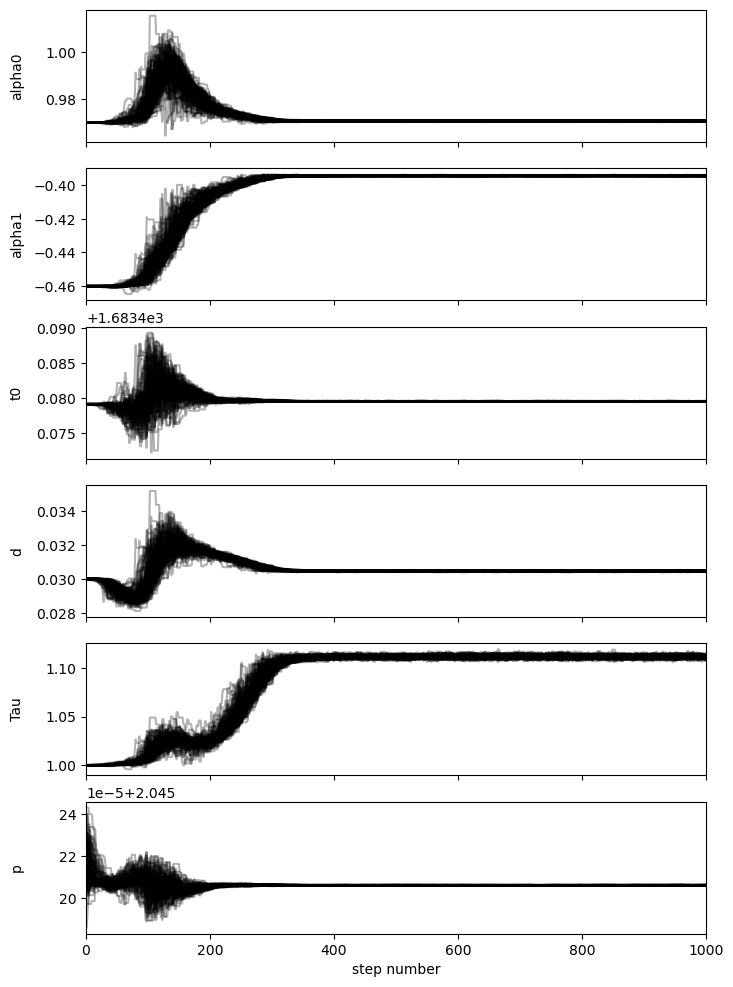

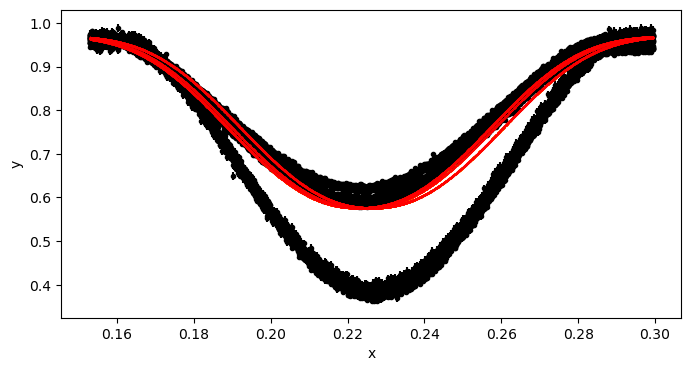

mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p = 0.97069735960858, -0.39440622544749016, 1683.4795921732793, 0.030462333707786608, 1.1118006681028716, 2.045206282737052
std_p: 5.7281188616104385e-08


In [44]:
# use MCMC to refine the period

use_mcmc_to_fit_period = True


if use_mcmc_to_fit_period:
    import etv_functions_with_period as etvp

    etv_functions.enable_info_log_for_jupyter()
        
    # MCMC result
    # mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p = 0.97069735960858, -0.39440622544749016, 1683.4795921732793, 0.030462333707786608, 1.1118006681028716, 2.045206282737052
    # std_p: 5.7281188616104385e-08    
    mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p, fit_params_p_stats = etvp.run_mcmc_initial_fit_p(
        data_primary[:],
        [0.97, -0.46, t0_primary, 0.030, 1.0, period],
        nruns=1000, discard=600, 
        # nruns=20, discard=1, 
        pool=-1,
        plot_chains=True,
        plot=True,
        also_return_stats=True,
    )
    print("mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p = " + ", ".join([str(v) for v in [mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p]]))
    print("std_p:", fit_params_p_stats["std_p"])
    !$NOTIFY_CMD "Fitting period done."

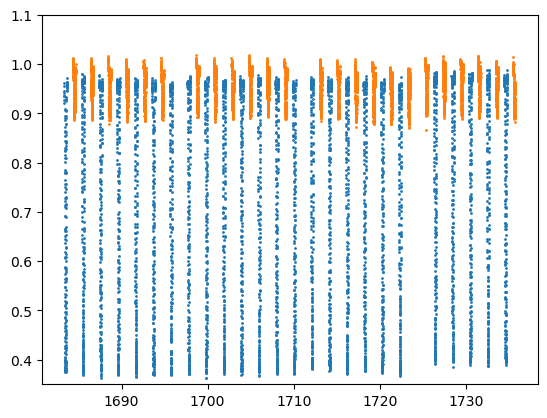

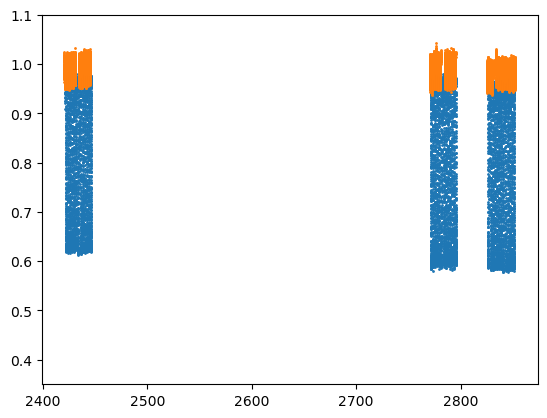

In [65]:
data_primary_p1 = data_primary[data_primary.time < 1800]
data_secondary_p1 = data_secondary[data_secondary.time < 1800]
plt.scatter(data_primary_p1.time, data_primary_p1.flux, s=1);
plt.scatter(data_secondary_p1.time, data_secondary_p1.flux, s=1);
plt.ylim(0.35, 1.1)
plt.show()

# --
data_primary_p2 = data_primary[data_primary.time > 1800]
data_secondary_p2 = data_secondary[data_secondary.time > 1800]
plt.scatter(data_primary_p2.time, data_primary_p2.flux, s=1);
plt.scatter(data_secondary_p2.time, data_secondary_p2.flux, s=1);
plt.ylim(0.35, 1.1)
plt.show()

emcee parallel enabled, use 5 CPUs.


100%|██████████████████████████████████████████████████████████| 1000/1000 [01:06<00:00, 15.09it/s]


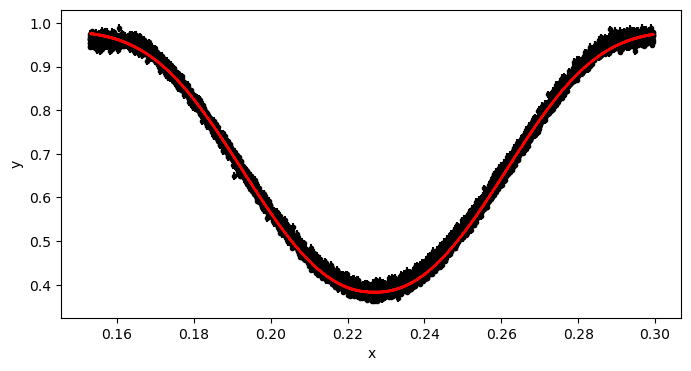

emcee parallel enabled, use 5 CPUs.


100%|██████████████████████████████████████████████████████████| 1000/1000 [01:07<00:00, 14.81it/s]


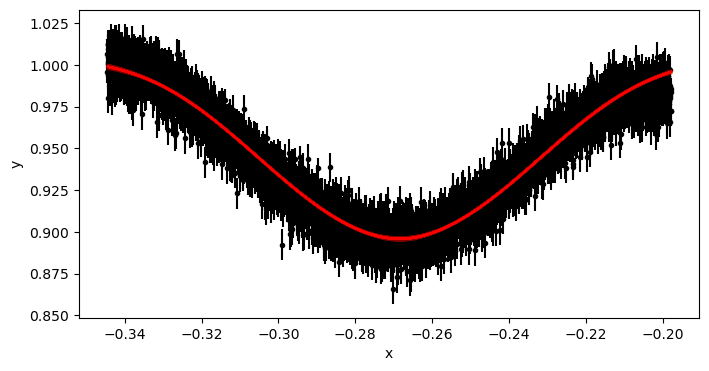

In [68]:
# run the initial model fit using MCMC for the primary and secondary eclipses 
run_init_fit = True

if run_init_fit:
    etv_functions.enable_info_log_for_jupyter()
    mean_alpha0_p1, mean_alpha1_p1, mean_t0_p1, mean_d_p1, mean_Tau_p1 = etv_functions.run_mcmc_initial_fit(data_primary_p1, start_vals, nruns = 1000, pool=-1, plot_chains = False, plot = True)
    if t0_secondary is not None:
        mean_alpha0_s_p1, mean_alpha1_s_p1, mean_t0_s_p1, mean_d_s_p1, mean_Tau_s_p1 = etv_functions.run_mcmc_initial_fit(data_secondary_p1, start_vals_s, nruns = 1000, pool=-1, plot_chains = False, plot = True)
    !$NOTIFY_CMD "Initial fit (part 1) done"


emcee parallel enabled, use 5 CPUs.


100%|██████████████████████████████████████████████████████████| 1000/1000 [01:16<00:00, 13.15it/s]


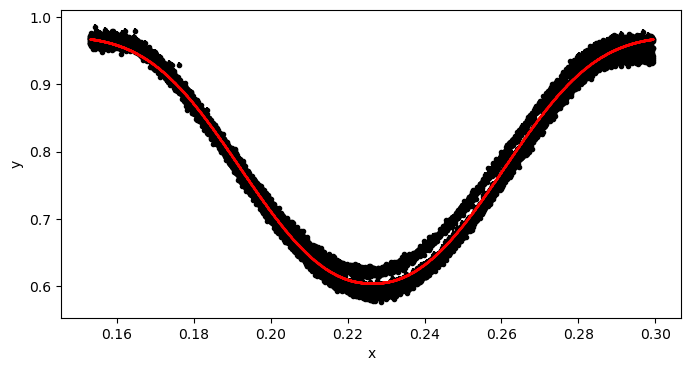

emcee parallel enabled, use 5 CPUs.


100%|██████████████████████████████████████████████████████████| 1000/1000 [01:15<00:00, 13.19it/s]


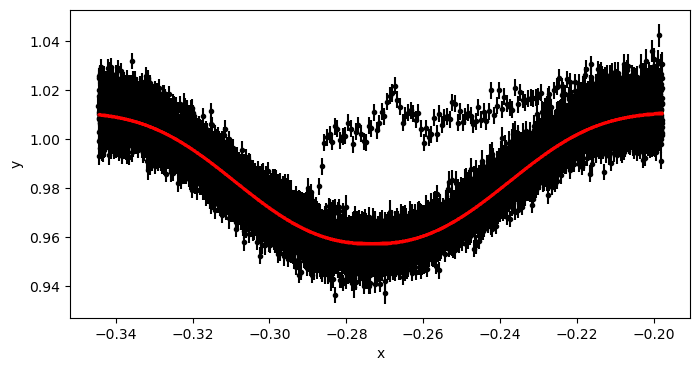

In [69]:
# Part 2
if run_init_fit:
    etv_functions.enable_info_log_for_jupyter()
    mean_alpha0_p2, mean_alpha1_p2, mean_t0_p2, mean_d_p2, mean_Tau_p2 = etv_functions.run_mcmc_initial_fit(data_primary_p2, start_vals, nruns = 1000, pool=-1, plot_chains = False, plot = True)
    if t0_secondary is not None:
        mean_alpha0_s_p2, mean_alpha1_s_p2, mean_t0_s_p2, mean_d_s_p2, mean_Tau_s_p2 = etv_functions.run_mcmc_initial_fit(data_secondary_p2, start_vals_s, nruns = 1000, pool=-1, plot_chains = False, plot = True)
    !$NOTIFY_CMD "Initial fit (part 2) done"    

In [ ]:
if not run_init_fit:  # case init fit has been previously saved and to be reussed
    print("Use pre-defined inital model params:")
    # initial fit params from TESS data
    mean_alpha0_p1, mean_alpha1_p1, mean_t0_p1, mean_d_p1, mean_Tau_p1 = 0.9833005865410819, -0.5991347579558142, 0.22684753496425836, 0.030705075190488623, 1.0997973133463397
    mean_alpha0_s_p1, mean_alpha1_s_p1, mean_t0_s_p1, mean_d_s_p1, mean_Tau_s_p1 = 1.0033610288814825, -0.107331315327335, -0.2685880551421833, 0.03600403505989863, 0.9427094250355323
    mean_alpha0_p2, mean_alpha1_p2, mean_t0_p2, mean_d_p2, mean_Tau_p2 = 0.972219078422855, -0.3674102100064864, 0.22631094478539177, 0.03079642595140196, 1.0938956900670778
    mean_alpha0_s_p2, mean_alpha1_s_p2, mean_t0_s_p2, mean_d_s_p2, mean_Tau_s_p2 = 1.01116069933887, -0.05374889050040259, -0.2733870719767836, 0.030698723245334028, 1.1812832297871605

    # etv_functions.plot_initial_guess(data_primary, ph_binned, flux_binned, err_binned, *[mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau])
    # etv_functions.plot_initial_guess(data_secondary, ph_binned_s, flux_binned_s, err_binned_s, *[mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s])    

In [70]:
print("Initial model params:")  # For information, and they can be copied to the cell above for future reuse

print("mean_alpha0_p1, mean_alpha1_p1, mean_t0_p1, mean_d_p1, mean_Tau_p1 = " + ", ".join([str(v) for v in [mean_alpha0_p1, mean_alpha1_p1, mean_t0_p1, mean_d_p1, mean_Tau_p1]]))
if t0_secondary is not None:
    print("mean_alpha0_s_p1, mean_alpha1_s_p1, mean_t0_s_p1, mean_d_s_p1, mean_Tau_s_p1 = " + ", ".join([str(v) for v in [mean_alpha0_s_p1, mean_alpha1_s_p1, mean_t0_s_p1, mean_d_s_p1, mean_Tau_s_p1]]))

# ---
print("mean_alpha0_p2, mean_alpha1_p2, mean_t0_p2, mean_d_p2, mean_Tau_p2 = " + ", ".join([str(v) for v in [mean_alpha0_p2, mean_alpha1_p2, mean_t0_p2, mean_d_p2, mean_Tau_p2]]))
if t0_secondary is not None:
    print("mean_alpha0_s_p2, mean_alpha1_s_p2, mean_t0_s_p2, mean_d_s_p2, mean_Tau_s_p2 = " + ", ".join([str(v) for v in [mean_alpha0_s_p2, mean_alpha1_s_p2, mean_t0_s_p2, mean_d_s_p2, mean_Tau_s_p2]]))    

Initial model params:
mean_alpha0_p1, mean_alpha1_p1, mean_t0_p1, mean_d_p1, mean_Tau_p1 = 0.9833005865410819, -0.5991347579558142, 0.22684753496425836, 0.030705075190488623, 1.0997973133463397
mean_alpha0_s_p1, mean_alpha1_s_p1, mean_t0_s_p1, mean_d_s_p1, mean_Tau_s_p1 = 1.0033610288814825, -0.107331315327335, -0.2685880551421833, 0.03600403505989863, 0.9427094250355323
mean_alpha0_p2, mean_alpha1_p2, mean_t0_p2, mean_d_p2, mean_Tau_p2 = 0.972219078422855, -0.3674102100064864, 0.22631094478539177, 0.03079642595140196, 1.0938956900670778
mean_alpha0_s_p2, mean_alpha1_s_p2, mean_t0_s_p2, mean_d_s_p2, mean_Tau_s_p2 = 1.01116069933887, -0.05374889050040259, -0.2733870719767836, 0.030698723245334028, 1.1812832297871605


571

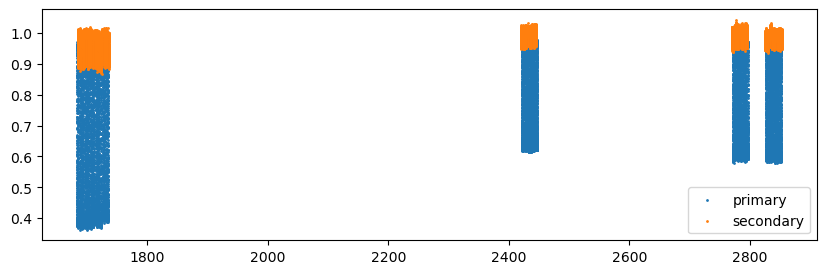

In [87]:
fig = plt.subplots(figsize=(10, 3), sharex=True)
plt.scatter(data_primary.time,data_primary.flux , s = 1, label = 'primary')
if t0_secondary is not None:
    plt.scatter(data_secondary.time,data_secondary.flux , s = 1, label = 'secondary')
plt.legend()

# calculate the number of transits there are within the data 
n_transits = int((max(data_primary.time) - min(data_primary.time)) / period)
n_transits

1683.4792 2.045206 1683.4792


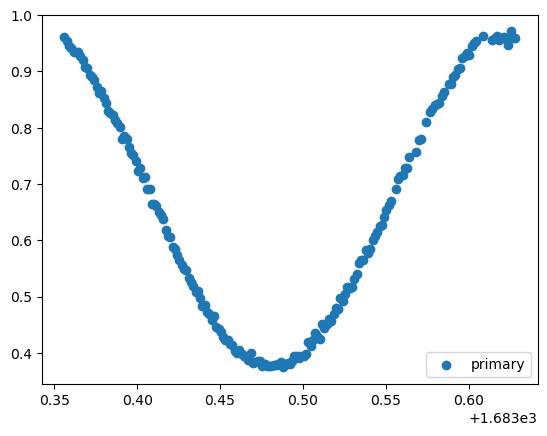

1683.4792 2.045206 1685.524406


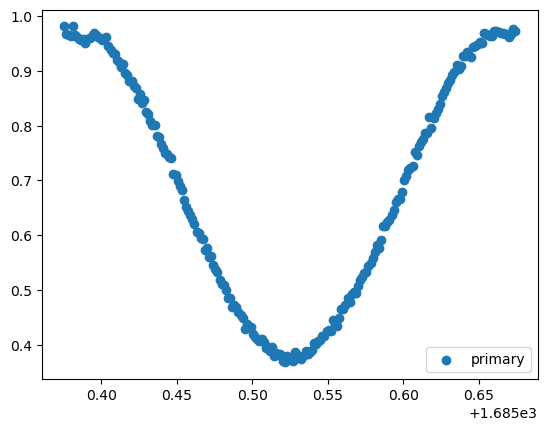

1683.4792 2.045206 1687.569612


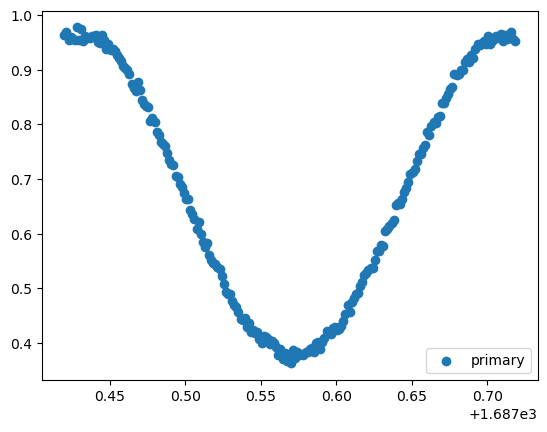

1684.5072 2.045206 1684.5072


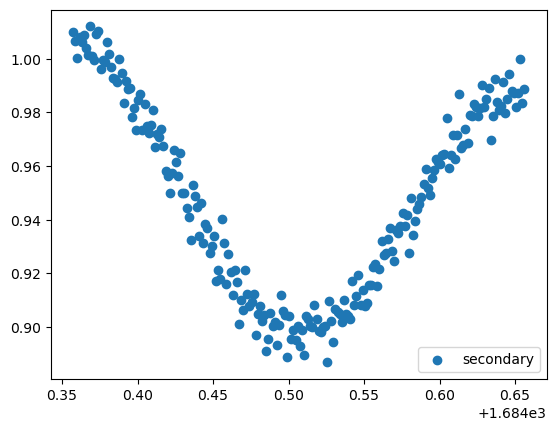

1684.5072 2.045206 1686.552406


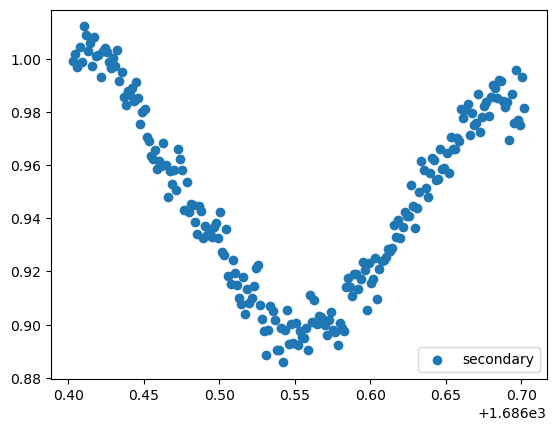

1684.5072 2.045206 1688.597612


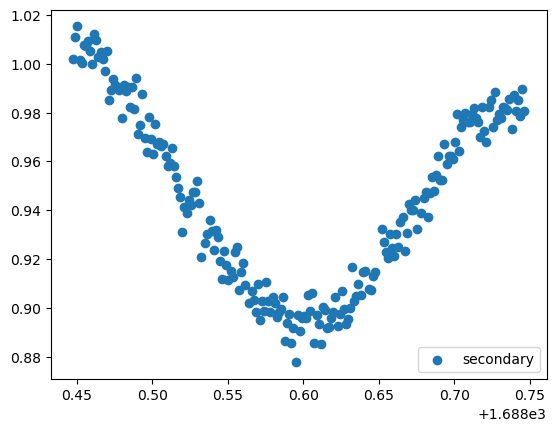

In [54]:
tr_index = range(0,n_transits)

for i in tr_index[0:3]:        
    transit_time = t0_primary+(period*i)
    x = np.array(data_primary.time)
    y = np.array(data_primary.flux) 
    yerr = np.array(data_primary.err)
    
    print (t0_primary, period, transit_time)
    
    mask = (x > (transit_time - (0.2*period))) & (x < (transit_time + (0.2*period))) 
    
    x = np.array(x[mask])
    y = np.array(y[mask]) 
    yerr = np.array(yerr[mask])
    fig, ax = plt.subplots()
    plt.scatter(x,y, label="primary")
    plt.legend(loc="lower right")
    plt.show()
    

if t0_secondary is not None:
    for i in tr_index[0:3]:        
        transit_time = t0_secondary+(period*i)
        x = np.array(data_secondary.time)
        y = np.array(data_secondary.flux) 
        yerr = np.array(data_secondary.err)
        
        print (t0_secondary, period, transit_time)
        
        mask = (x > (transit_time - (0.2*period))) & (x < (transit_time + (0.2*period))) 
        
        x = np.array(x[mask])
        y = np.array(y[mask]) 
        yerr = np.array(yerr[mask])
        fig, ax = plt.subplots()
        plt.scatter(x,y, label="secondary")
        plt.legend(loc="lower right")
        plt.show()

### Fit indiviudla eclipses

Split the data into 2 parts because the depth changes so drastically

Fitting individual primary eclipses...
25
Creating new manifest file
1683.4792 0.9833005865410819 -0.5991347579558142 0.22684753496425836


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 326.65it/s]


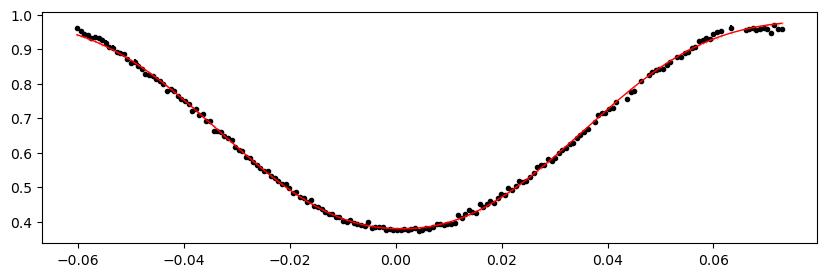

1685.524406 0.9833005865410819 -0.5991347579558142 0.22684753496425836


100%|███████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 312.41it/s]


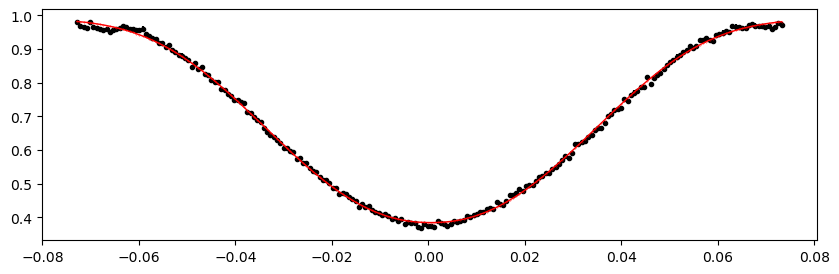

1687.569612 0.9833005865410819 -0.5991347579558142 0.22684753496425836


100%|███████████████████████████████████████████████████████| 10000/10000 [00:34<00:00, 288.57it/s]


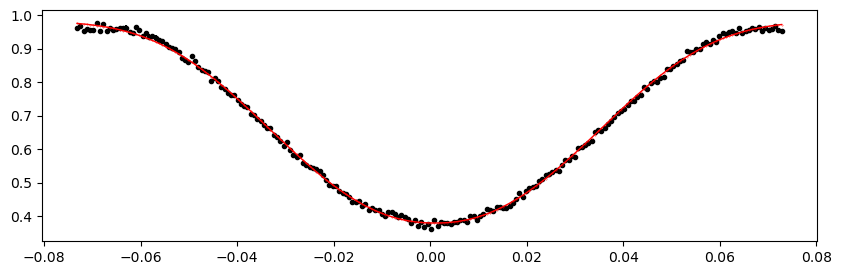

1689.614818 0.9833005865410819 -0.5991347579558142 0.22684753496425836


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 314.74it/s]


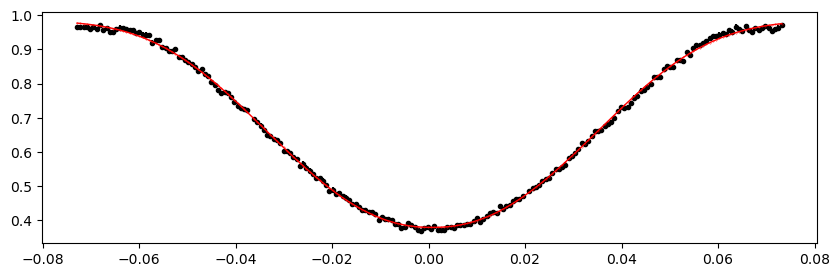

1691.660024 0.9833005865410819 -0.5991347579558142 0.22684753496425836


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 317.97it/s]


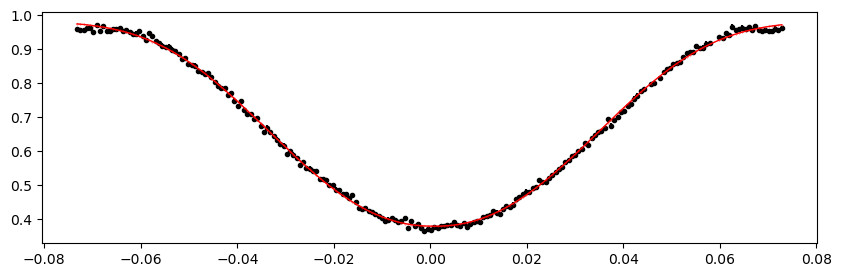

1693.70523 0.9833005865410819 -0.5991347579558142 0.22684753496425836


100%|███████████████████████████████████████████████████████| 10000/10000 [00:34<00:00, 292.46it/s]


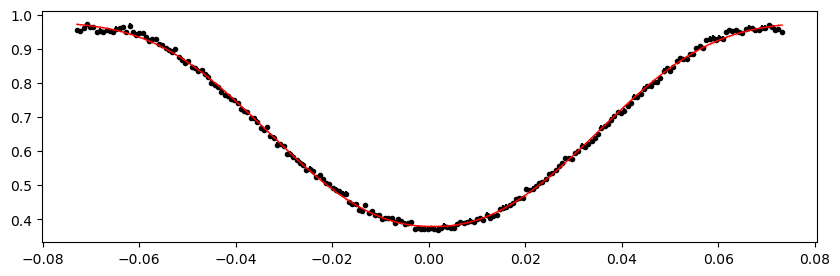

1695.750436 0.9833005865410819 -0.5991347579558142 0.22684753496425836


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 317.77it/s]


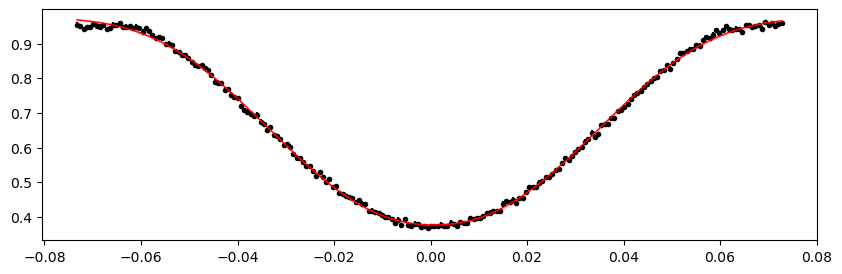

1697.795642 0.9833005865410819 -0.5991347579558142 0.22684753496425836


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 318.49it/s]


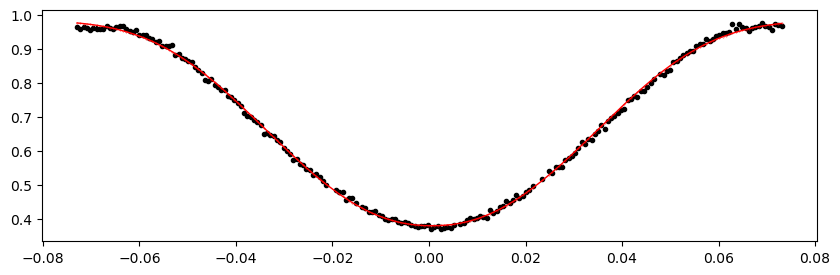

1699.840848 0.9833005865410819 -0.5991347579558142 0.22684753496425836


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 321.23it/s]


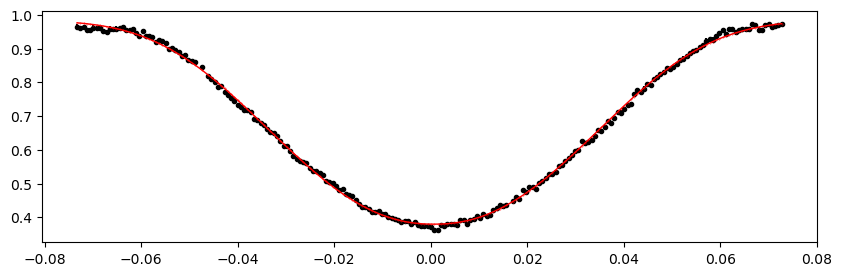

1701.886054 0.9833005865410819 -0.5991347579558142 0.22684753496425836


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 320.75it/s]


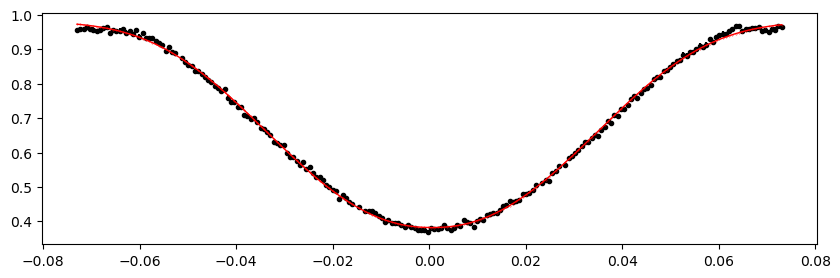

1703.93126 0.9833005865410819 -0.5991347579558142 0.22684753496425836


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 317.67it/s]


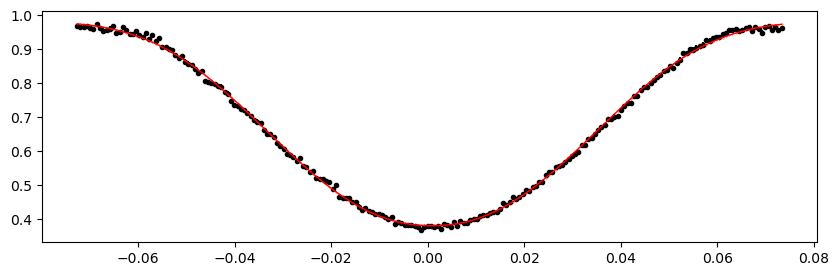

1705.976466 0.9833005865410819 -0.5991347579558142 0.22684753496425836


100%|███████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 307.60it/s]


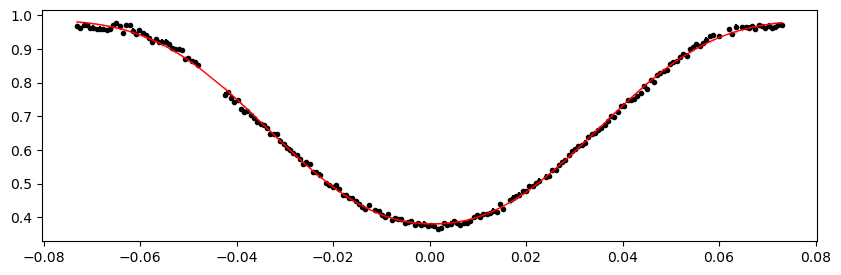

1708.021672 0.9833005865410819 -0.5991347579558142 0.22684753496425836


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 314.50it/s]


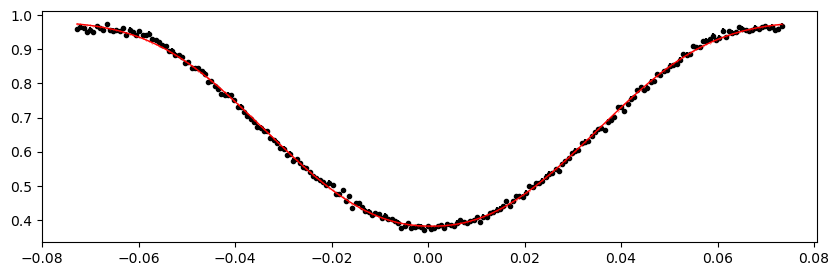

1710.066878 0.9833005865410819 -0.5991347579558142 0.22684753496425836


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 318.69it/s]


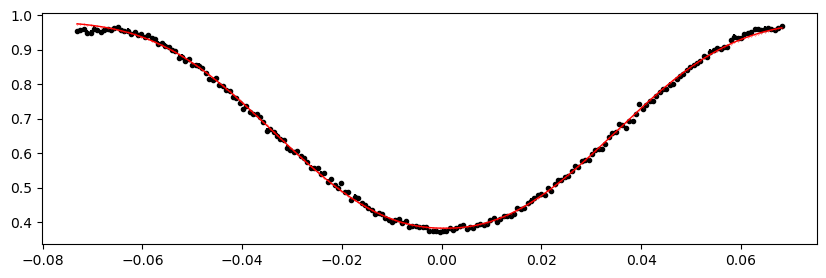

1712.112084 0.9833005865410819 -0.5991347579558142 0.22684753496425836


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 322.75it/s]


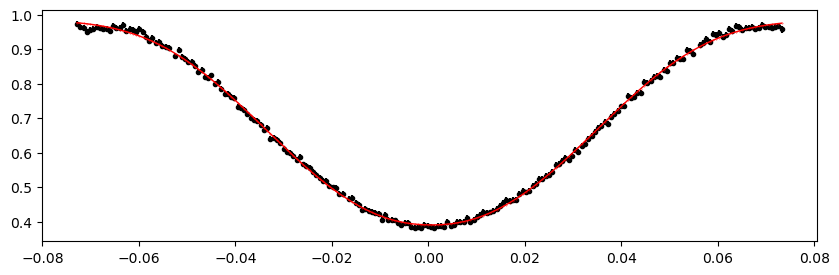

1714.15729 0.9833005865410819 -0.5991347579558142 0.22684753496425836


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 322.90it/s]


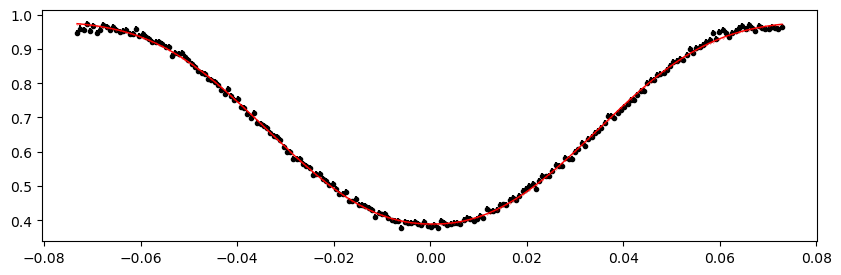

1716.2024959999999 0.9833005865410819 -0.5991347579558142 0.22684753496425836


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 325.19it/s]


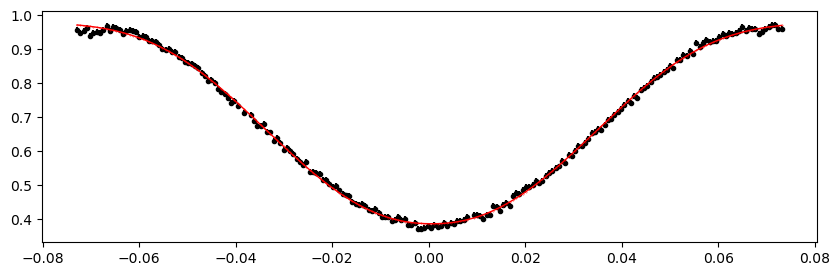

1718.247702 0.9833005865410819 -0.5991347579558142 0.22684753496425836


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 324.01it/s]


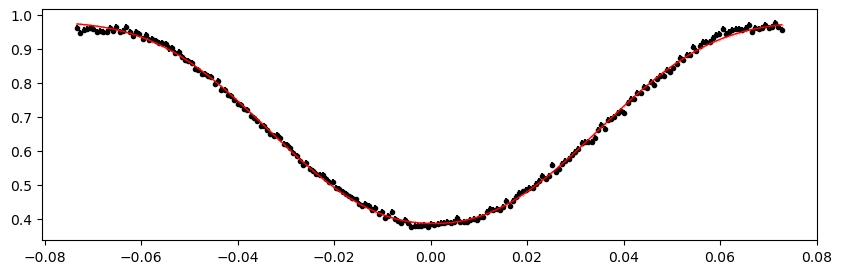

1720.292908 0.9833005865410819 -0.5991347579558142 0.22684753496425836


100%|███████████████████████████████████████████████████████| 10000/10000 [00:36<00:00, 272.49it/s]


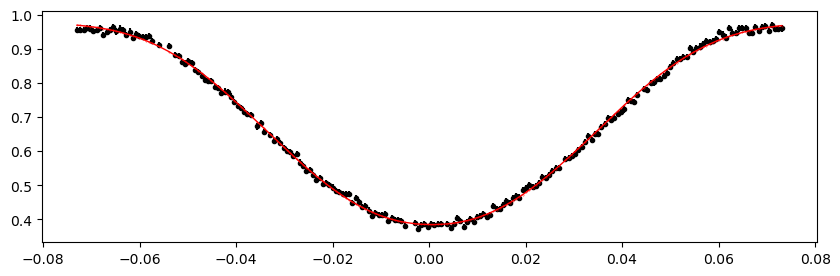

1722.338114 0.9833005865410819 -0.5991347579558142 0.22684753496425836


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 317.22it/s]


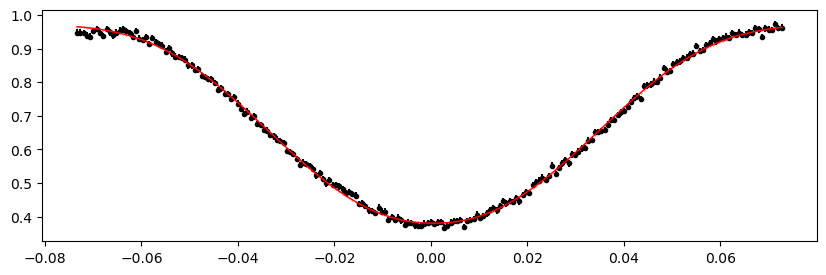

1726.428526 0.9833005865410819 -0.5991347579558142 0.22684753496425836


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 320.22it/s]


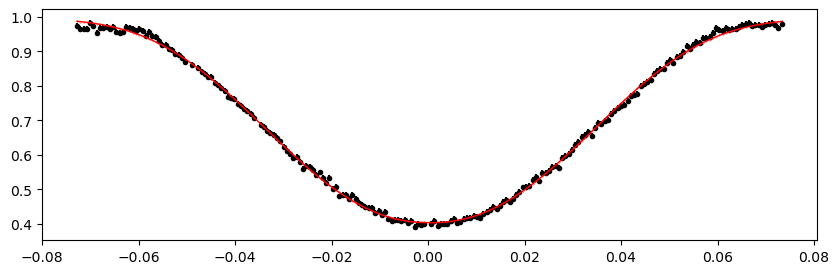

1728.473732 0.9833005865410819 -0.5991347579558142 0.22684753496425836


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 314.93it/s]


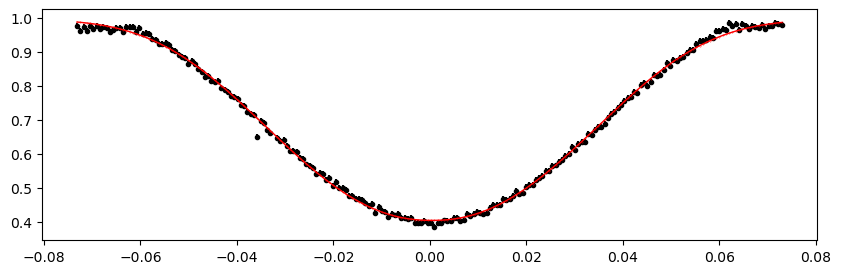

1730.518938 0.9833005865410819 -0.5991347579558142 0.22684753496425836


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 315.11it/s]


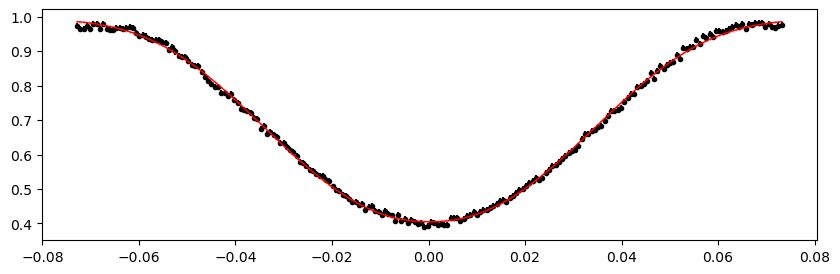

1732.564144 0.9833005865410819 -0.5991347579558142 0.22684753496425836


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 325.88it/s]


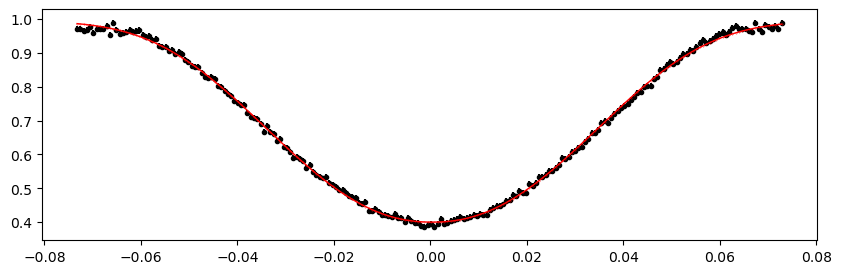

Fitting individual secondary eclipses...
Creating new manifest file
1684.5072 1.0033610288814825 -0.107331315327335 -0.2685880551421833


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 319.75it/s]


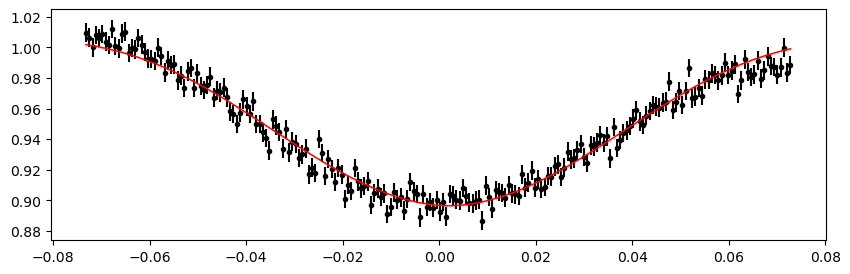

1686.552406 1.0033610288814825 -0.107331315327335 -0.2685880551421833


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 321.74it/s]


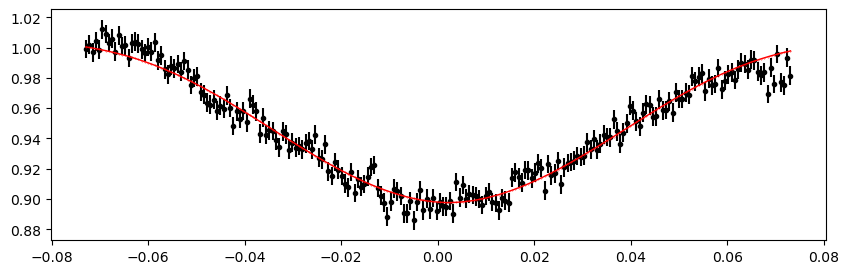

1688.597612 1.0033610288814825 -0.107331315327335 -0.2685880551421833


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 324.41it/s]


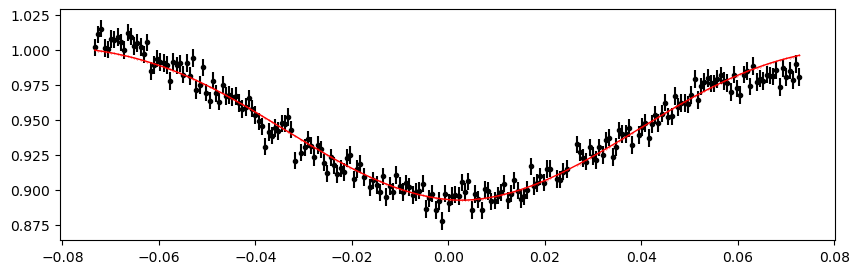

1690.642818 1.0033610288814825 -0.107331315327335 -0.2685880551421833


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 320.44it/s]


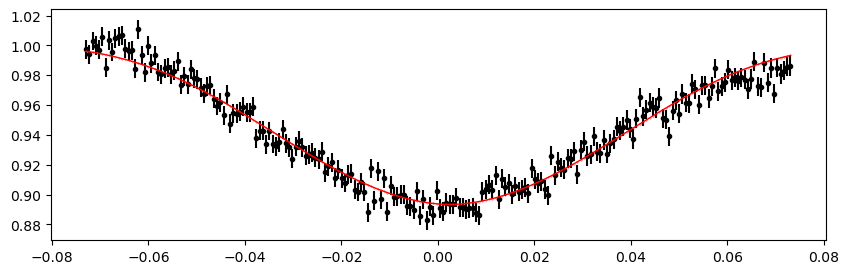

1692.688024 1.0033610288814825 -0.107331315327335 -0.2685880551421833


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 325.66it/s]


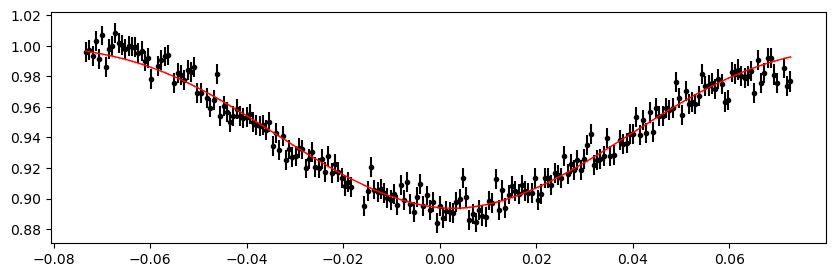

1694.73323 1.0033610288814825 -0.107331315327335 -0.2685880551421833


100%|███████████████████████████████████████████████████████| 10000/10000 [00:33<00:00, 297.84it/s]


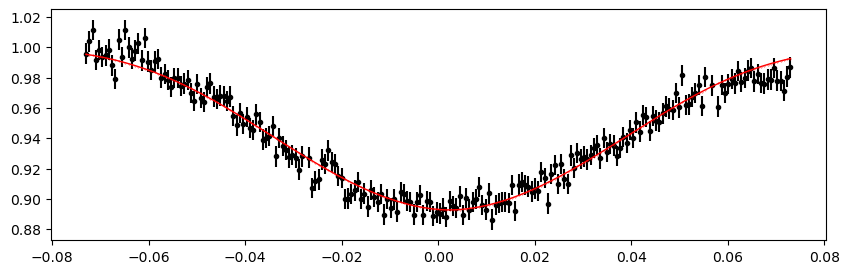

1698.823642 1.0033610288814825 -0.107331315327335 -0.2685880551421833


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 323.61it/s]


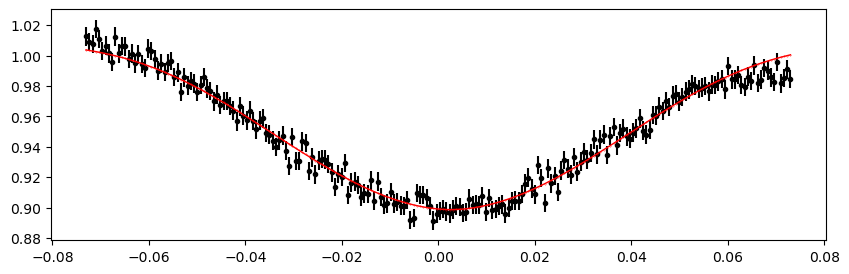

1700.868848 1.0033610288814825 -0.107331315327335 -0.2685880551421833


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 322.20it/s]


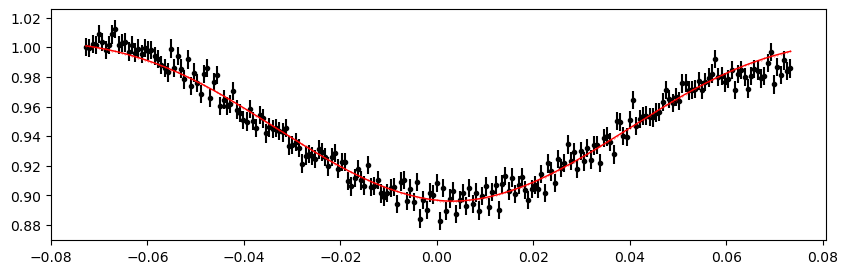

1702.914054 1.0033610288814825 -0.107331315327335 -0.2685880551421833


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 324.20it/s]


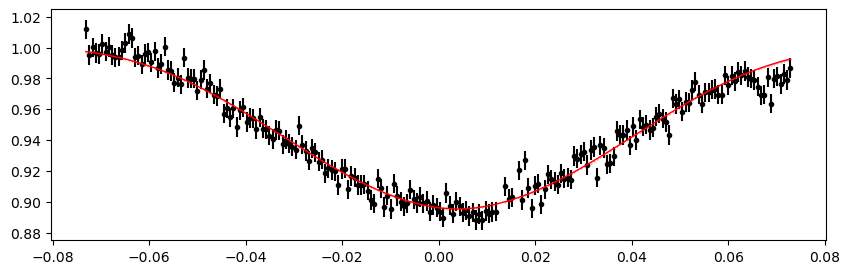

1704.95926 1.0033610288814825 -0.107331315327335 -0.2685880551421833


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 323.29it/s]


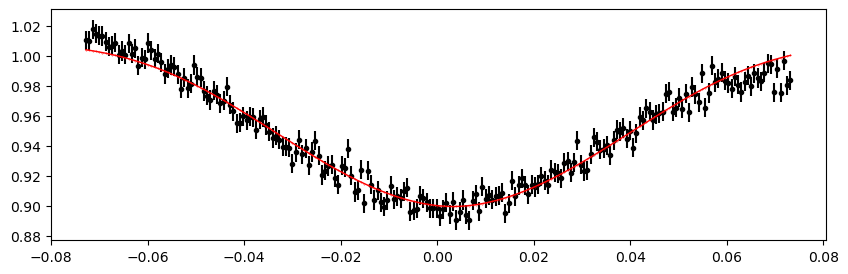

1707.004466 1.0033610288814825 -0.107331315327335 -0.2685880551421833


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 319.84it/s]


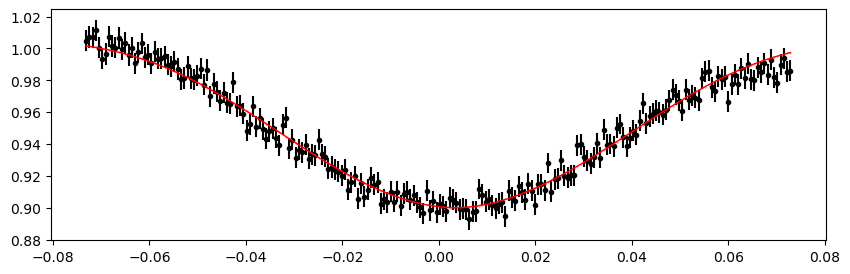

1709.049672 1.0033610288814825 -0.107331315327335 -0.2685880551421833


100%|███████████████████████████████████████████████████████| 10000/10000 [00:33<00:00, 297.12it/s]


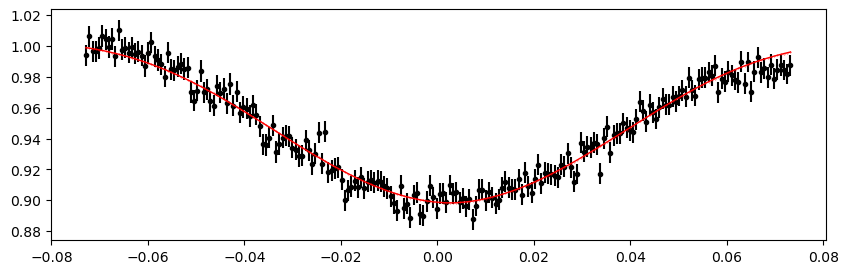

1713.1400840000001 1.0033610288814825 -0.107331315327335 -0.2685880551421833


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 325.52it/s]


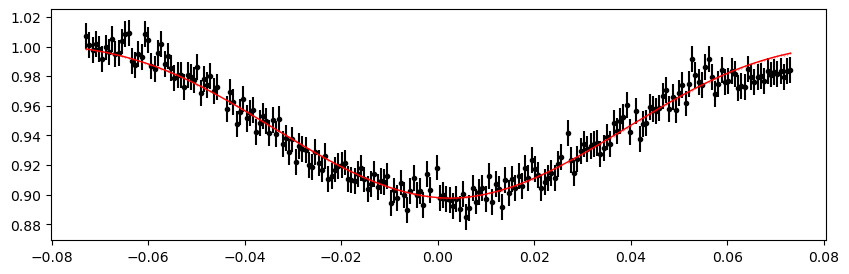

1715.18529 1.0033610288814825 -0.107331315327335 -0.2685880551421833


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 323.88it/s]


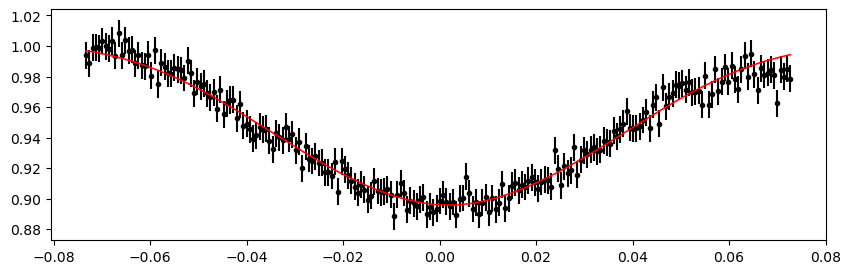

1717.230496 1.0033610288814825 -0.107331315327335 -0.2685880551421833


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 324.04it/s]


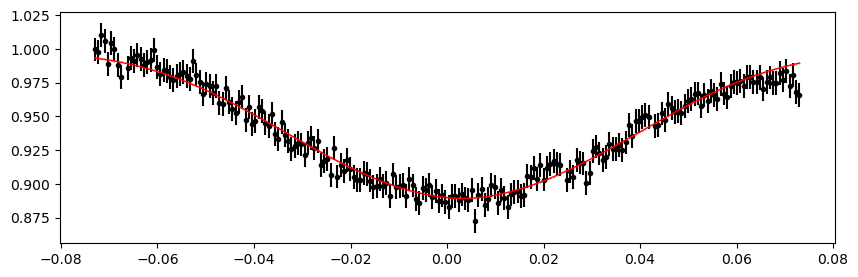

1719.275702 1.0033610288814825 -0.107331315327335 -0.2685880551421833


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 319.83it/s]


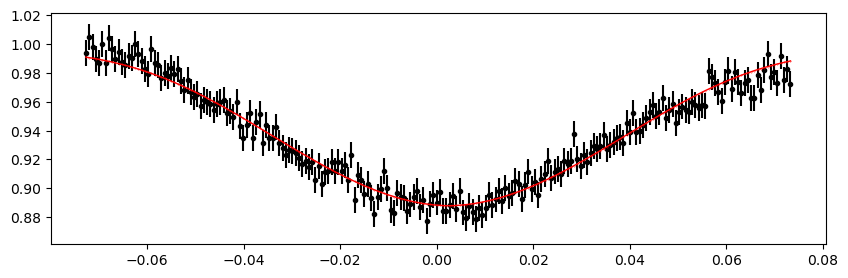

1721.320908 1.0033610288814825 -0.107331315327335 -0.2685880551421833


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 320.61it/s]


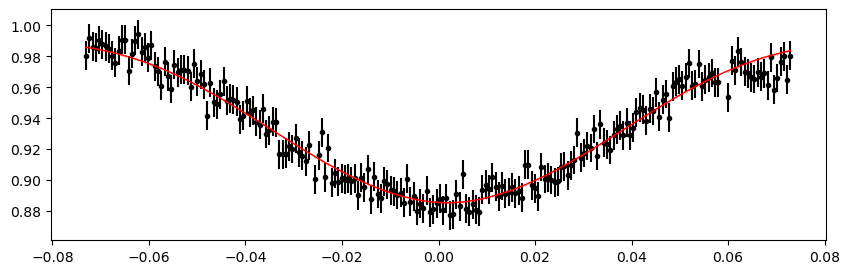

1723.366114 1.0033610288814825 -0.107331315327335 -0.2685880551421833


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 323.03it/s]


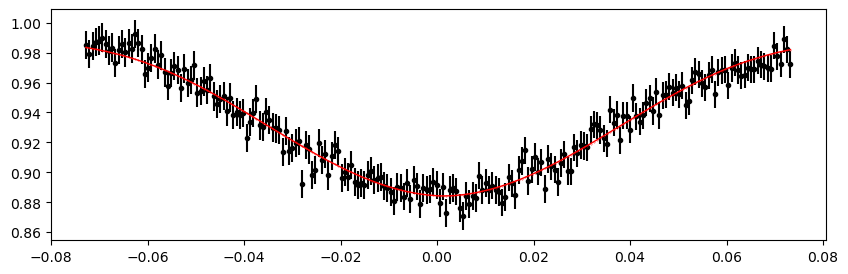

1725.41132 1.0033610288814825 -0.107331315327335 -0.2685880551421833


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 328.17it/s]


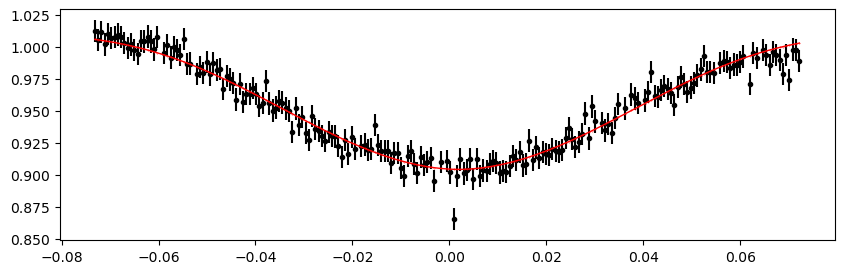

1727.456526 1.0033610288814825 -0.107331315327335 -0.2685880551421833


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 323.50it/s]


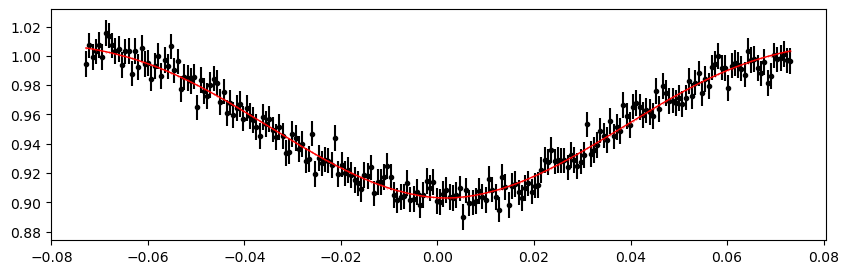

1729.501732 1.0033610288814825 -0.107331315327335 -0.2685880551421833


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 326.82it/s]


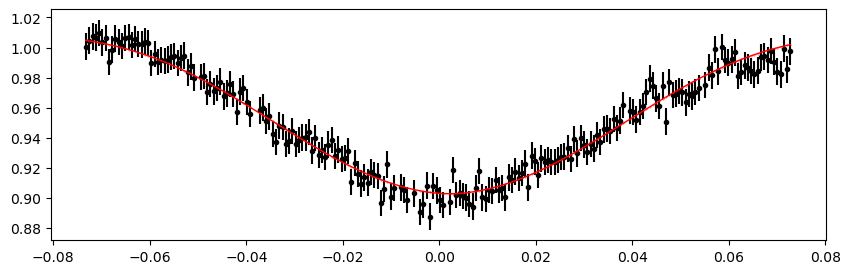

1731.546938 1.0033610288814825 -0.107331315327335 -0.2685880551421833


100%|███████████████████████████████████████████████████████| 10000/10000 [00:33<00:00, 299.65it/s]


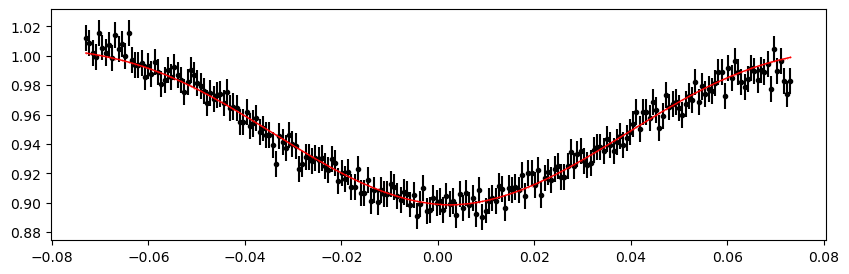

1733.592144 1.0033610288814825 -0.107331315327335 -0.2685880551421833


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 327.23it/s]


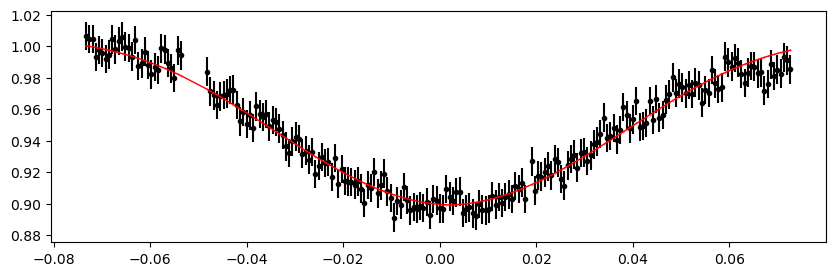

In [80]:
%matplotlib inline

# from importlib import reload
# reload(etv_functions)

print("Fitting individual primary eclipses...")
n_transits_p1 = int((max(data_primary_p1.time) - min(data_primary_p1.time)) / period)
print(n_transits_p1)
outfile_path_p1 = outfile_path.replace(".csv", "_p1.csv")
etv_functions.fit_each_eclipse(data_primary_p1, n_transits_p1, t0_primary, period, mean_alpha0_p1, mean_alpha1_p1, mean_t0_p1, mean_d_p1, mean_Tau_p1, outfile_path_p1,
                               min_number_data=20, 
                              )
!$NOTIFY_CMD "Individual primary eclipses (_p1) fit done"

# ---

%matplotlib inline

if t0_secondary is not None:
    print("Fitting individual secondary eclipses...")
    outfile_path_s_p1 = outfile_path_s.replace(".csv", "_p1.csv")
    etv_functions.fit_each_eclipse(data_secondary_p1, n_transits_p1, t0_secondary, period, mean_alpha0_s_p1, mean_alpha1_s_p1, mean_t0_s_p1, mean_d_s_p1, mean_Tau_s_p1, outfile_path_s_p1,
                                   min_number_data=20, 
                                  )
    !$NOTIFY_CMD "Individual secondary eclipses ((_p1) fit done"
else:
    print("No secondary eclipses defined. No-Op.")

Fitting individual primary eclipses...
Existing manifest file found, will skip previously processed LCs and append to end of manifest file
Number 361 has already been completed -- skip
Number 362 has already been completed -- skip
Number 363 has already been completed -- skip
Number 364 has already been completed -- skip
2429.97939 0.972219078422855 -0.3674102100064864 0.22631094478539177


100%|███████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 306.30it/s]


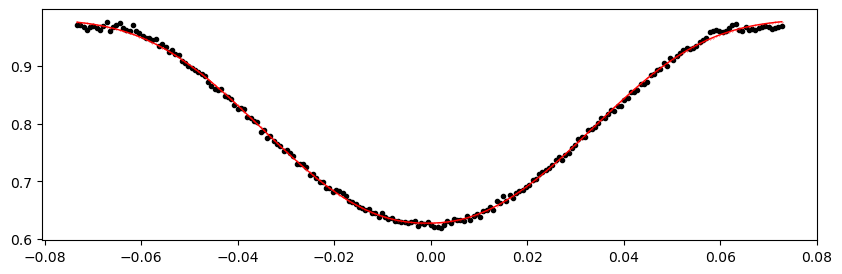

2432.024596 0.972219078422855 -0.3674102100064864 0.22631094478539177


100%|███████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 309.82it/s]


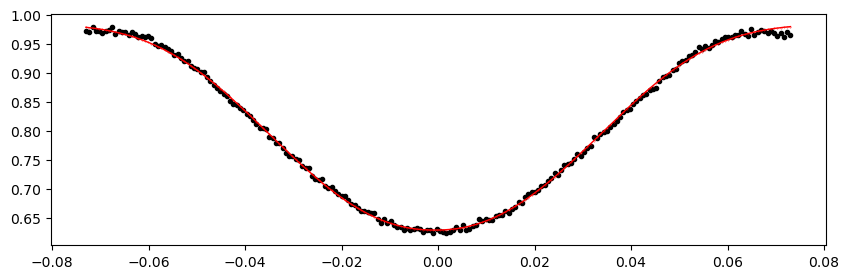

2434.069802 0.972219078422855 -0.3674102100064864 0.22631094478539177


100%|███████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 306.51it/s]


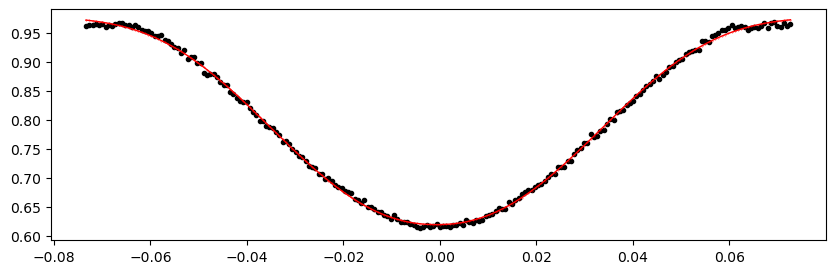

2436.1150079999998 0.972219078422855 -0.3674102100064864 0.22631094478539177


100%|███████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 303.89it/s]


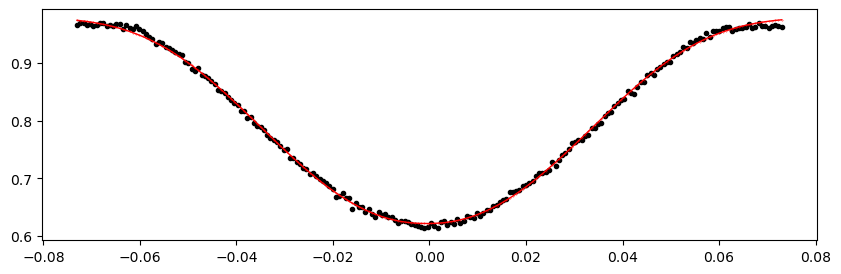

2438.160214 0.972219078422855 -0.3674102100064864 0.22631094478539177


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 312.74it/s]


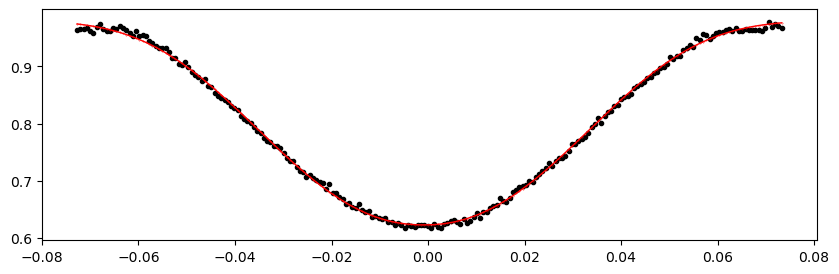

2440.20542 0.972219078422855 -0.3674102100064864 0.22631094478539177


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 315.96it/s]


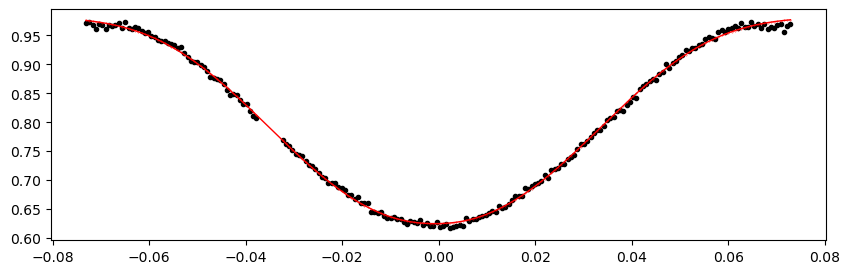

2442.250626 0.972219078422855 -0.3674102100064864 0.22631094478539177


100%|███████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 311.66it/s]


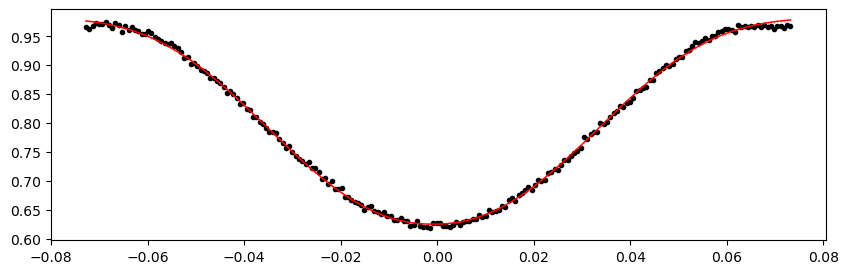

2444.295832 0.972219078422855 -0.3674102100064864 0.22631094478539177


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 313.24it/s]


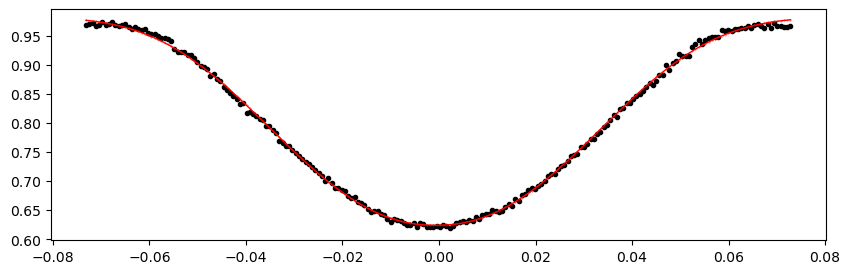

2446.341038 0.972219078422855 -0.3674102100064864 0.22631094478539177


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 314.12it/s]


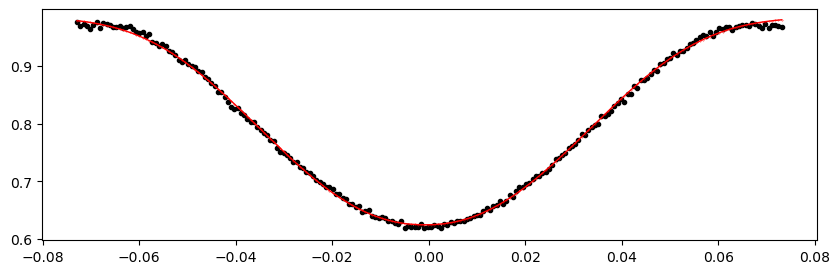

2771.528792 0.972219078422855 -0.3674102100064864 0.22631094478539177


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 315.56it/s]


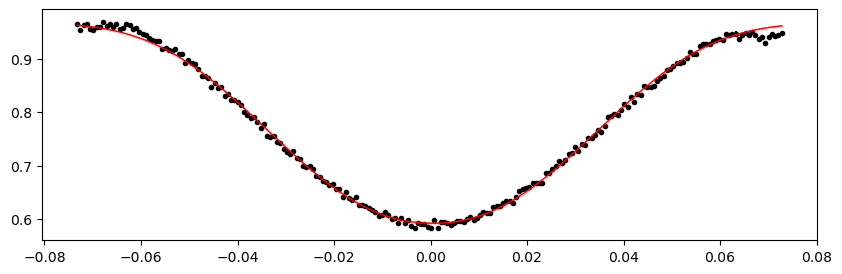

2773.573998 0.972219078422855 -0.3674102100064864 0.22631094478539177


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 320.88it/s]


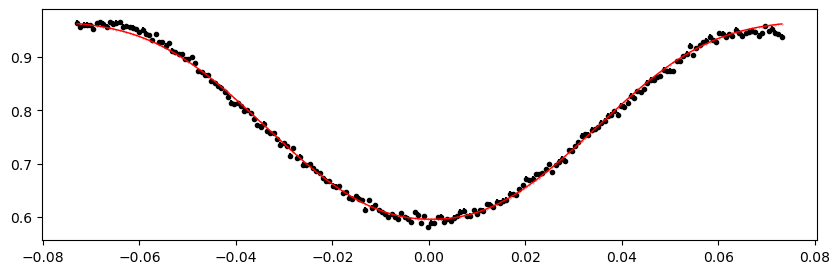

2775.6192039999996 0.972219078422855 -0.3674102100064864 0.22631094478539177


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 316.62it/s]


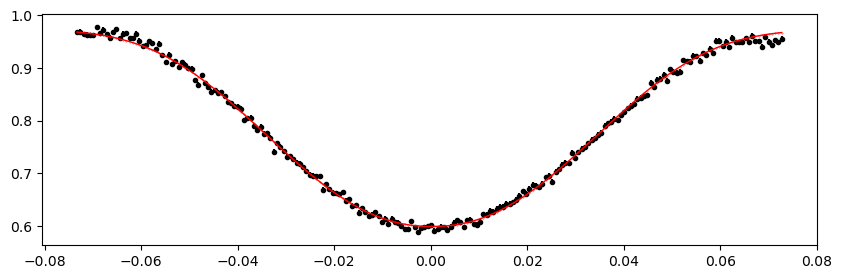

2777.66441 0.972219078422855 -0.3674102100064864 0.22631094478539177


100%|███████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 311.14it/s]


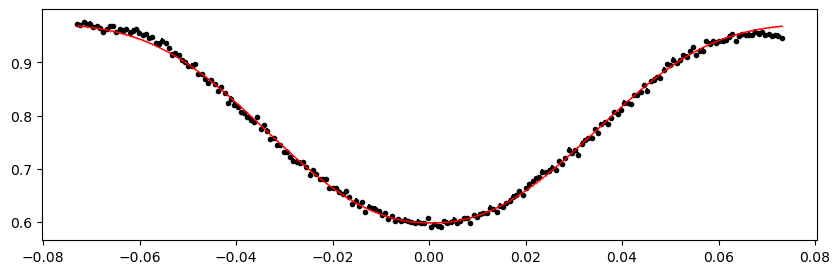

2779.709616 0.972219078422855 -0.3674102100064864 0.22631094478539177


100%|███████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 311.92it/s]


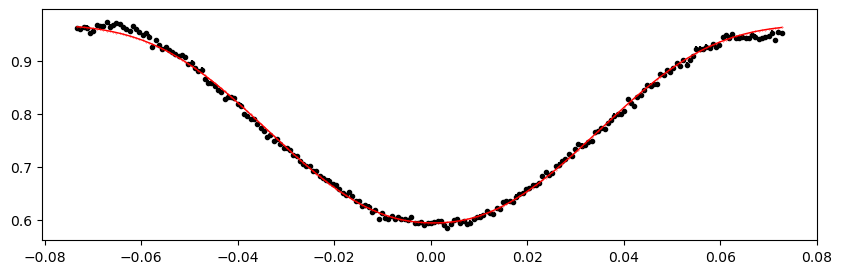

2781.754822 0.972219078422855 -0.3674102100064864 0.22631094478539177


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 315.06it/s]


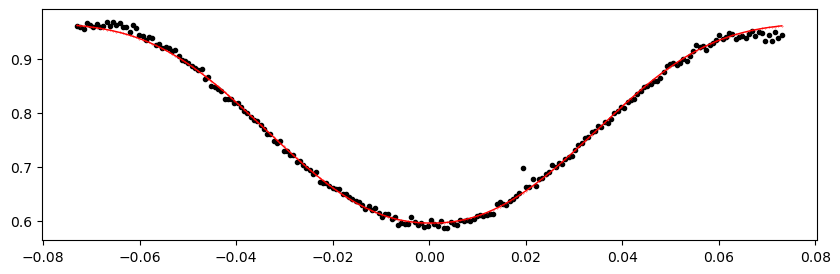

2783.8000279999997 0.972219078422855 -0.3674102100064864 0.22631094478539177


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 313.50it/s]


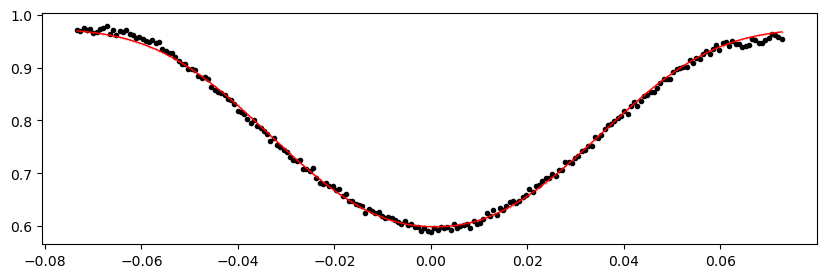

2785.845234 0.972219078422855 -0.3674102100064864 0.22631094478539177


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 315.67it/s]


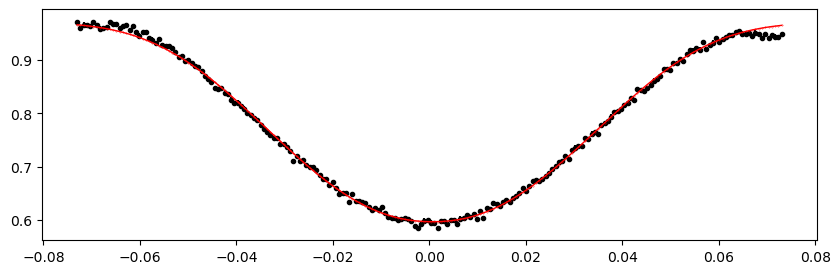

2787.89044 0.972219078422855 -0.3674102100064864 0.22631094478539177


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 317.06it/s]


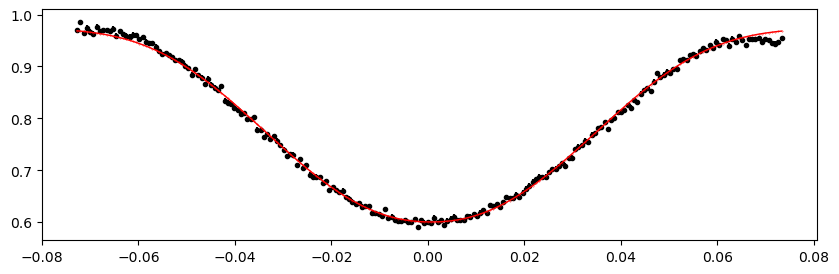

2789.935646 0.972219078422855 -0.3674102100064864 0.22631094478539177


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 316.18it/s]


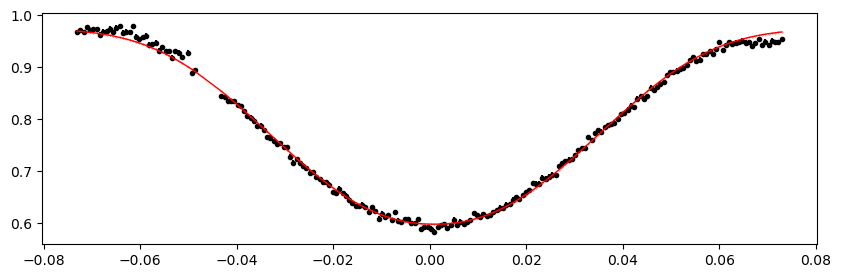

2791.9808519999997 0.972219078422855 -0.3674102100064864 0.22631094478539177


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 317.92it/s]


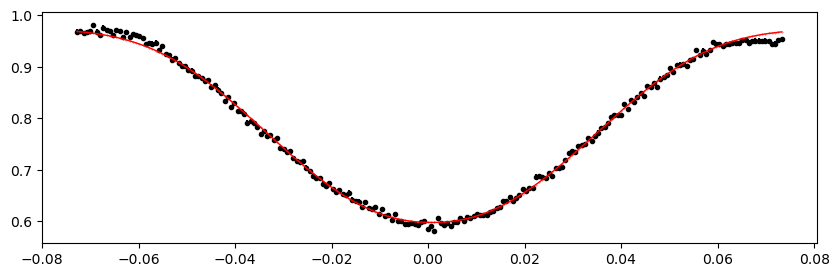

2794.026058 0.972219078422855 -0.3674102100064864 0.22631094478539177


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 313.38it/s]


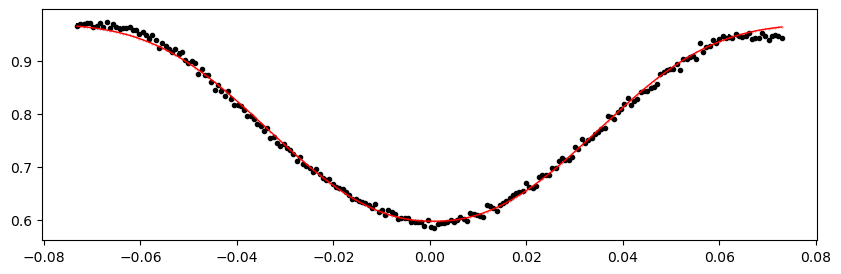

2796.071264 0.972219078422855 -0.3674102100064864 0.22631094478539177


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 334.67it/s]


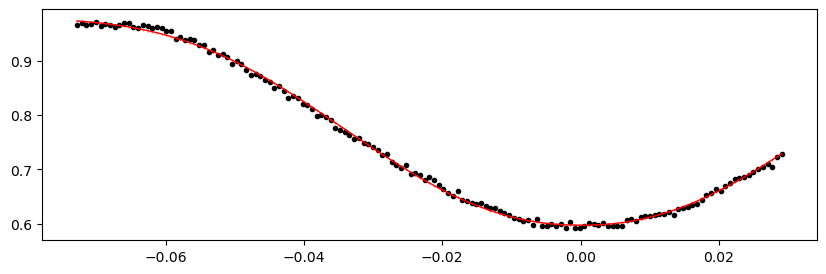

2826.7493539999996 0.972219078422855 -0.3674102100064864 0.22631094478539177


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 316.03it/s]


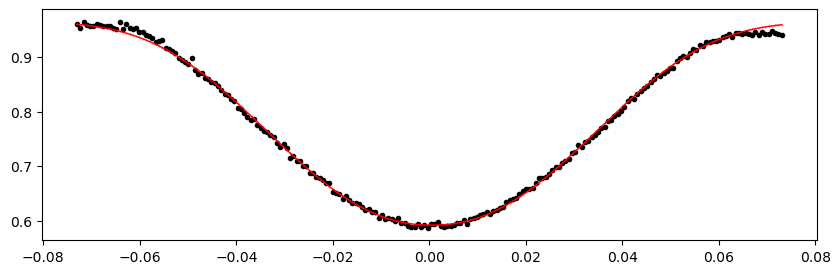

2828.79456 0.972219078422855 -0.3674102100064864 0.22631094478539177


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 320.94it/s]


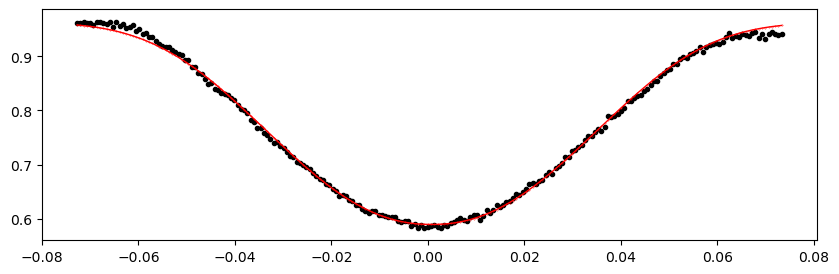

2830.839766 0.972219078422855 -0.3674102100064864 0.22631094478539177


100%|███████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 312.31it/s]


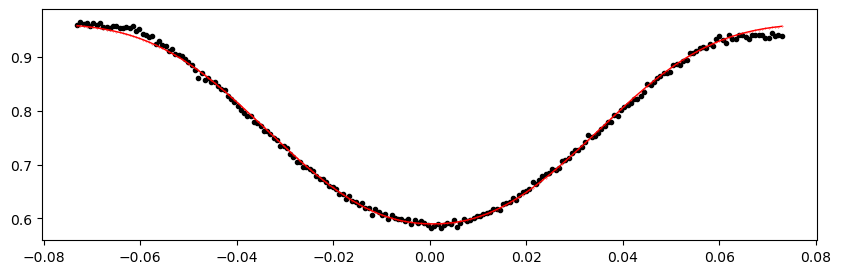

2832.884972 0.972219078422855 -0.3674102100064864 0.22631094478539177


100%|███████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 312.46it/s]


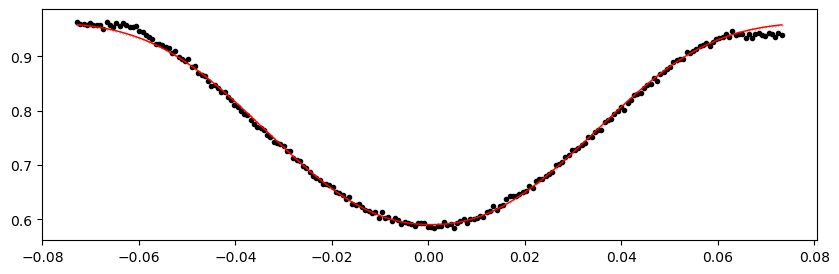

2834.9301779999996 0.972219078422855 -0.3674102100064864 0.22631094478539177


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 316.20it/s]


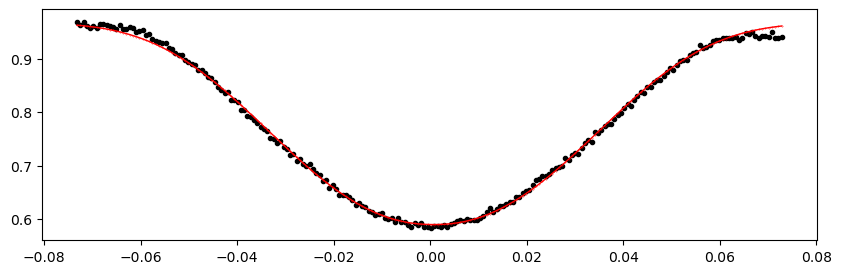

2836.975384 0.972219078422855 -0.3674102100064864 0.22631094478539177


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 314.57it/s]


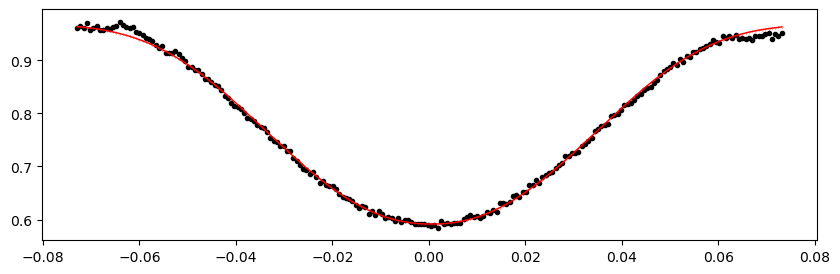

2839.02059 0.972219078422855 -0.3674102100064864 0.22631094478539177


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 315.90it/s]


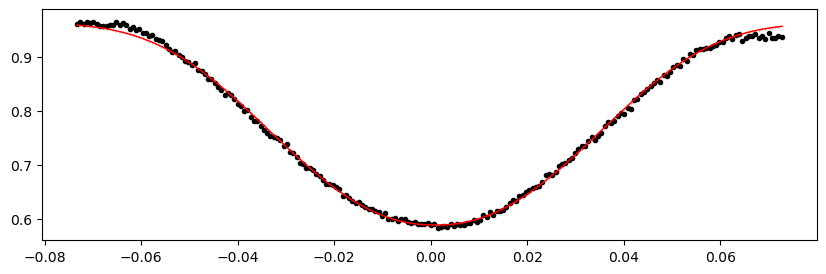

2841.065796 0.972219078422855 -0.3674102100064864 0.22631094478539177


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 319.47it/s]


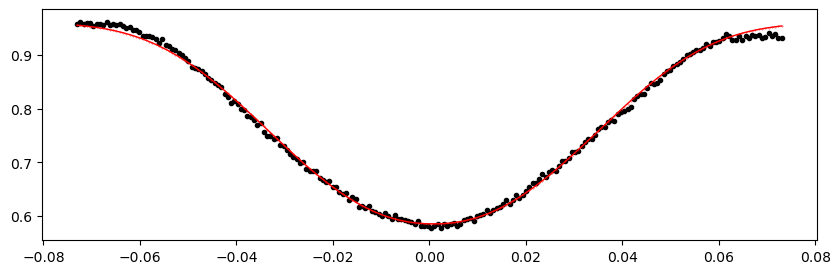

2843.1110019999996 0.972219078422855 -0.3674102100064864 0.22631094478539177


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 315.40it/s]


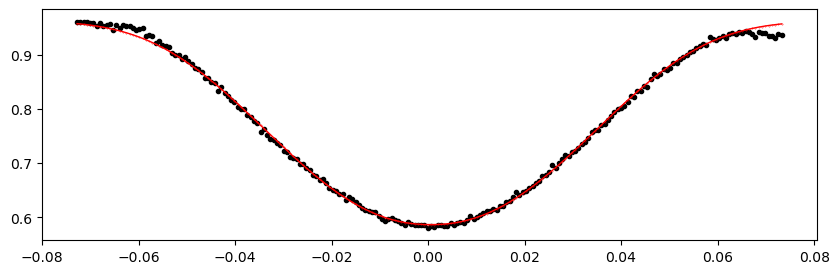

2845.156208 0.972219078422855 -0.3674102100064864 0.22631094478539177


100%|███████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 311.87it/s]


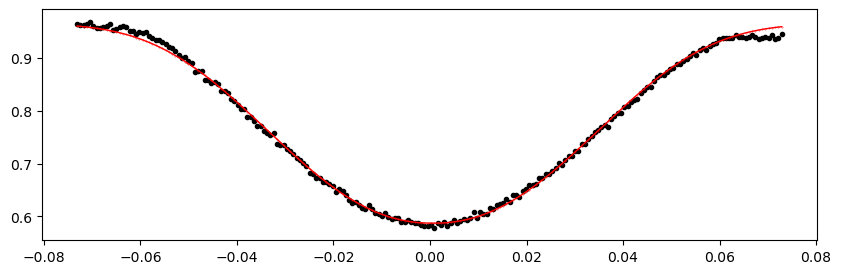

2847.201414 0.972219078422855 -0.3674102100064864 0.22631094478539177


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 314.65it/s]


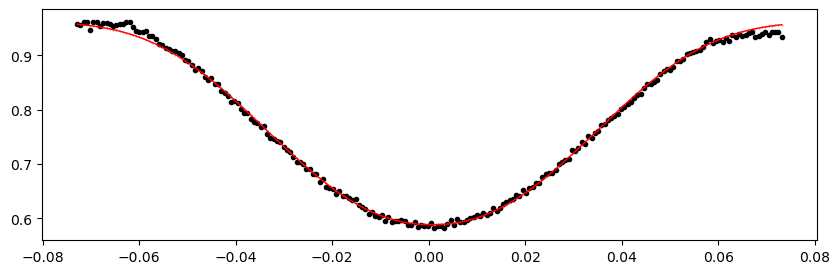

2849.24662 0.972219078422855 -0.3674102100064864 0.22631094478539177


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 318.58it/s]


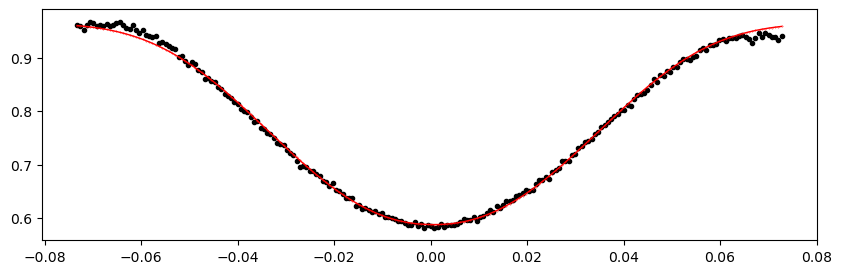

Fitting individual secondary eclipses...
Existing manifest file found, will skip previously processed LCs and append to end of manifest file
Number 360 has already been completed -- skip
Number 361 has already been completed -- skip
2424.871772 1.01116069933887 -0.05374889050040259 -0.2733870719767836


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 317.18it/s]


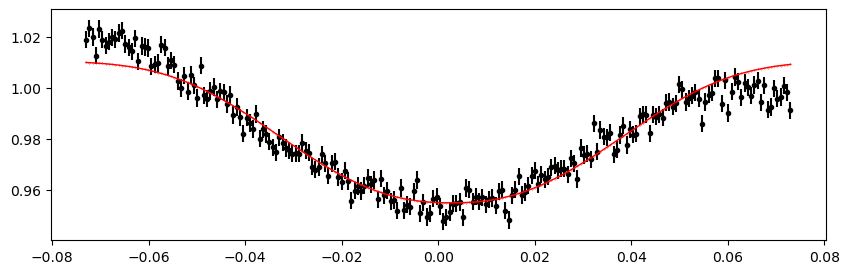

2426.916978 1.01116069933887 -0.05374889050040259 -0.2733870719767836


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 316.03it/s]


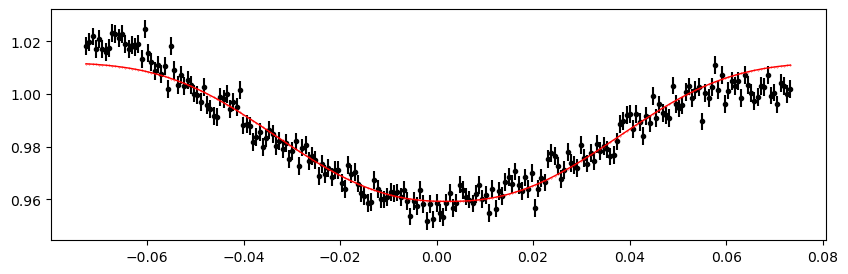

2428.962184 1.01116069933887 -0.05374889050040259 -0.2733870719767836


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 314.76it/s]


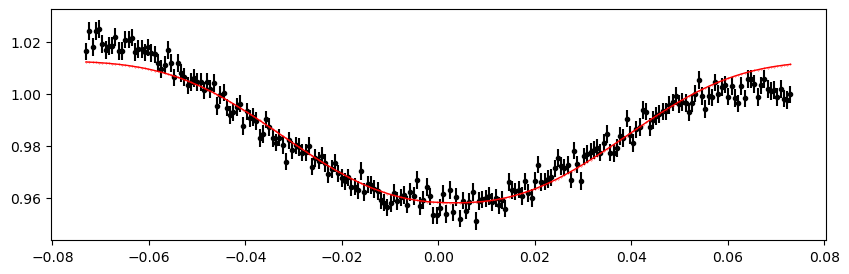

2431.0073899999998 1.01116069933887 -0.05374889050040259 -0.2733870719767836


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 314.80it/s]


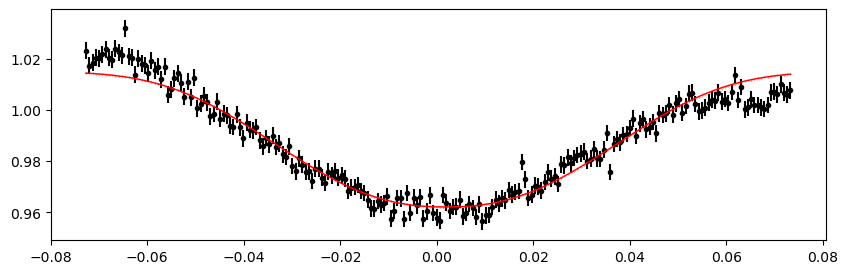

2435.0978020000002 1.01116069933887 -0.05374889050040259 -0.2733870719767836


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 314.96it/s]


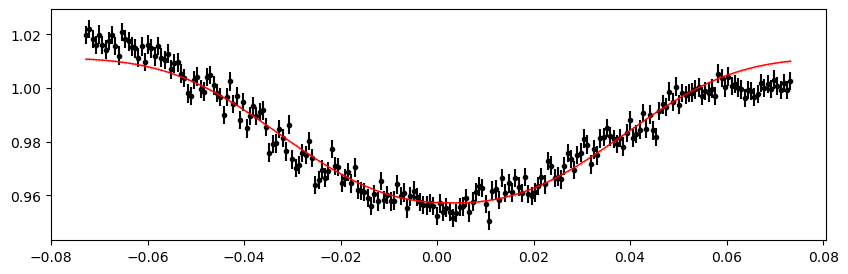

2437.143008 1.01116069933887 -0.05374889050040259 -0.2733870719767836


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 314.52it/s]


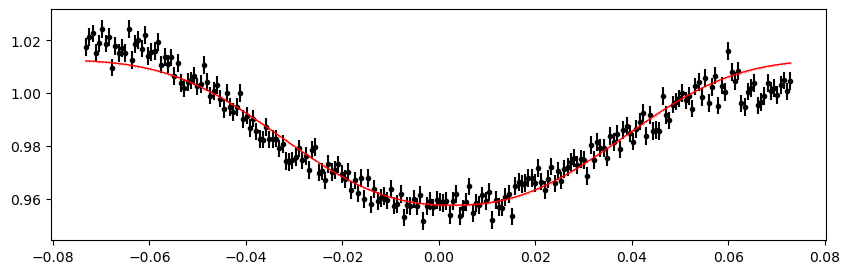

2439.188214 1.01116069933887 -0.05374889050040259 -0.2733870719767836


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 323.50it/s]


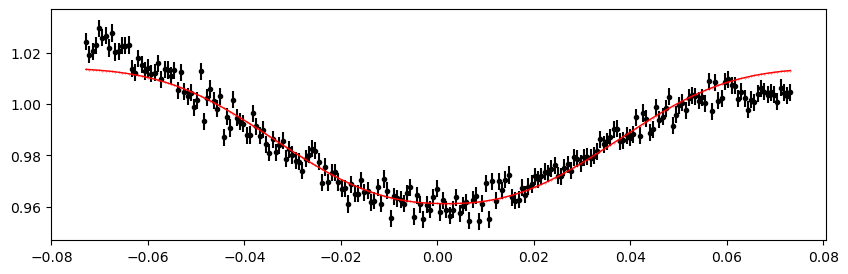

2441.23342 1.01116069933887 -0.05374889050040259 -0.2733870719767836


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 321.81it/s]


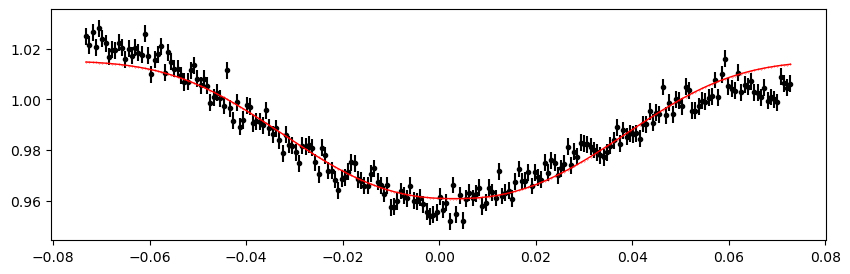

2443.278626 1.01116069933887 -0.05374889050040259 -0.2733870719767836


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 323.97it/s]


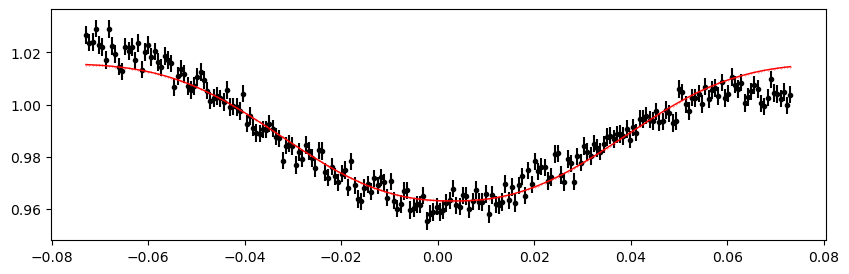

2445.323832 1.01116069933887 -0.05374889050040259 -0.2733870719767836


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 322.34it/s]


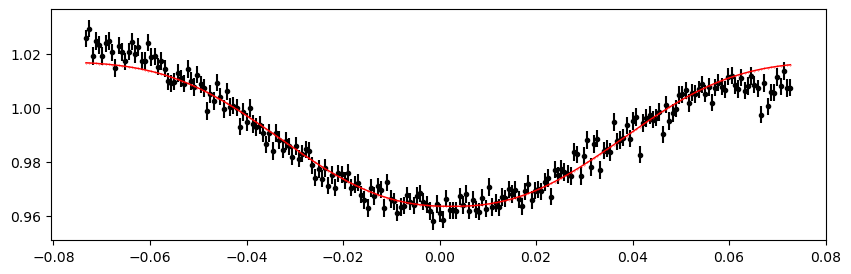

2770.5115859999996 1.01116069933887 -0.05374889050040259 -0.2733870719767836


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 323.16it/s]


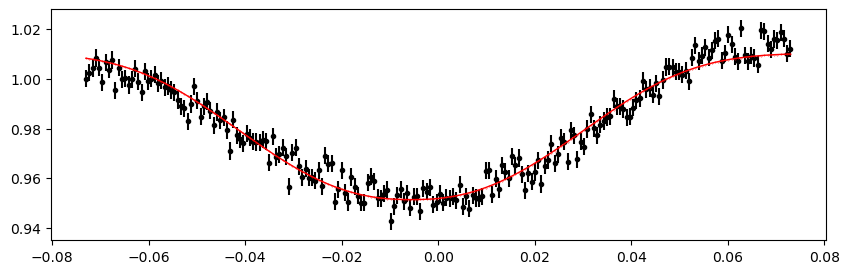

2772.556792 1.01116069933887 -0.05374889050040259 -0.2733870719767836


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 322.66it/s]


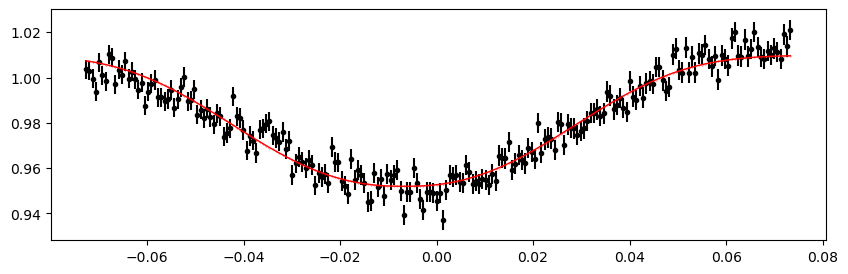

2774.601998 1.01116069933887 -0.05374889050040259 -0.2733870719767836


100%|███████████████████████████████████████████████████████| 10000/10000 [00:33<00:00, 298.81it/s]


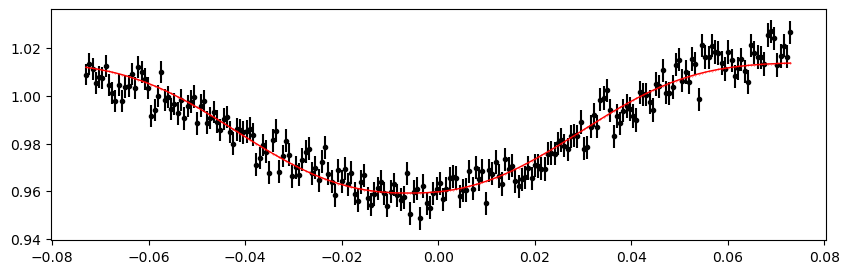

2776.647204 1.01116069933887 -0.05374889050040259 -0.2733870719767836


100%|███████████████████████████████████████████████████████| 10000/10000 [00:33<00:00, 297.62it/s]


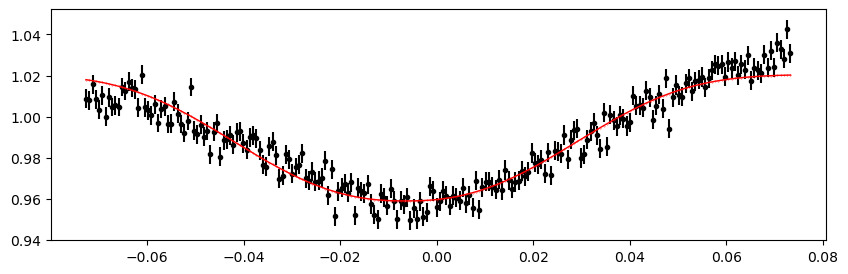

2778.6924099999997 1.01116069933887 -0.05374889050040259 -0.2733870719767836


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 323.33it/s]


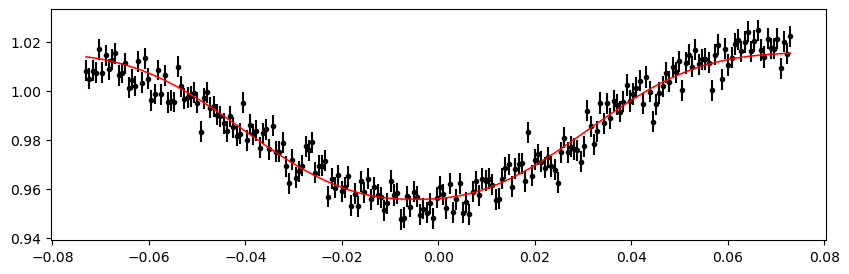

2780.737616 1.01116069933887 -0.05374889050040259 -0.2733870719767836


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 321.65it/s]


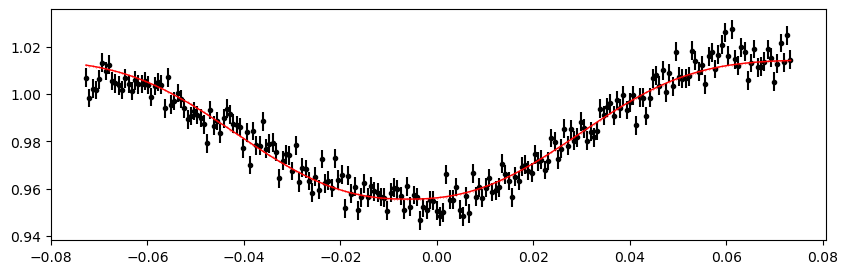

2784.828028 1.01116069933887 -0.05374889050040259 -0.2733870719767836


100%|███████████████████████████████████████████████████████| 10000/10000 [00:35<00:00, 283.28it/s]


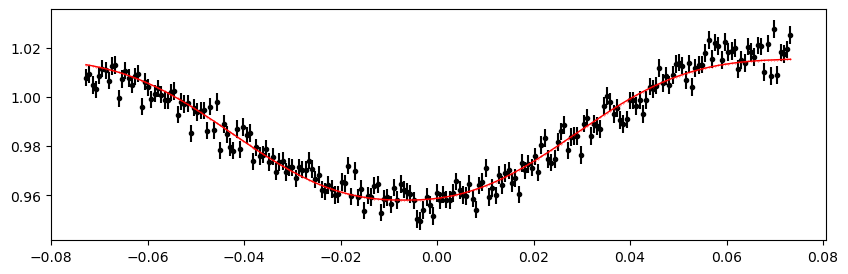

2786.8732339999997 1.01116069933887 -0.05374889050040259 -0.2733870719767836


100%|███████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 307.40it/s]


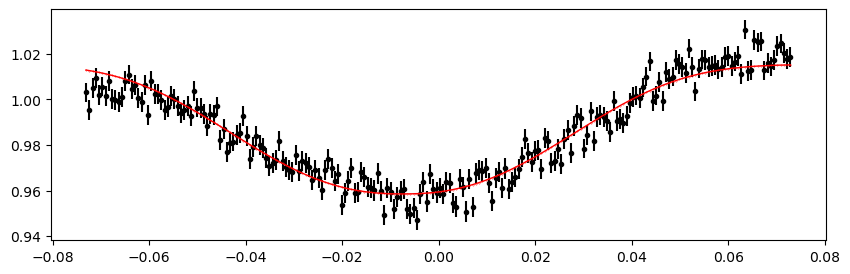

2788.91844 1.01116069933887 -0.05374889050040259 -0.2733870719767836


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 317.72it/s]


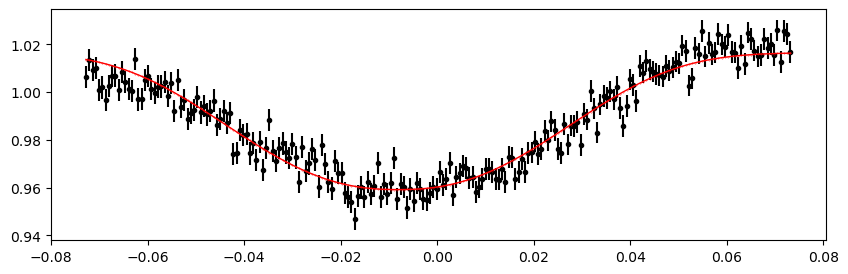

2790.963646 1.01116069933887 -0.05374889050040259 -0.2733870719767836


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 318.14it/s]


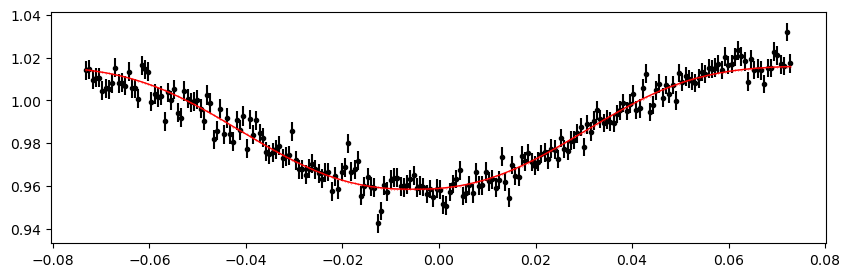

2793.008852 1.01116069933887 -0.05374889050040259 -0.2733870719767836


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 316.74it/s]


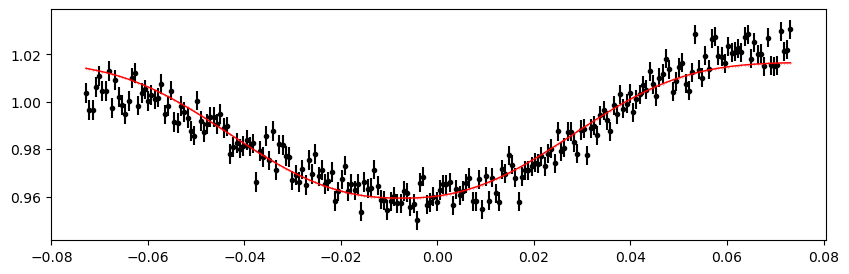

2795.0540579999997 1.01116069933887 -0.05374889050040259 -0.2733870719767836


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 317.27it/s]


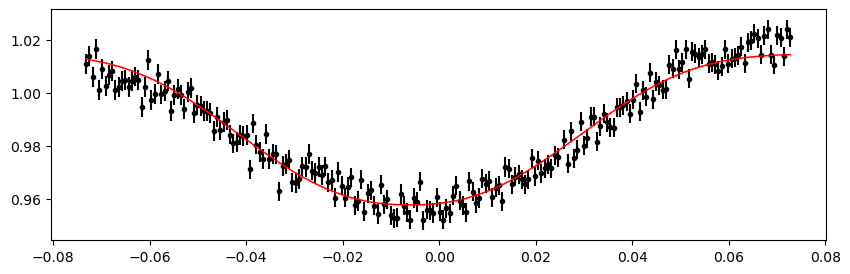

2825.732148 1.01116069933887 -0.05374889050040259 -0.2733870719767836


100%|███████████████████████████████████████████████████████| 10000/10000 [00:33<00:00, 296.25it/s]


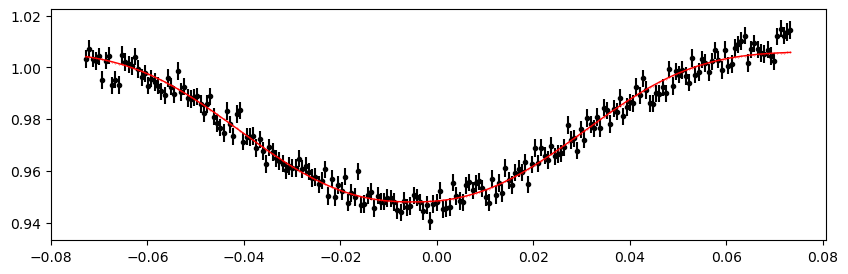

2827.777354 1.01116069933887 -0.05374889050040259 -0.2733870719767836


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 323.01it/s]


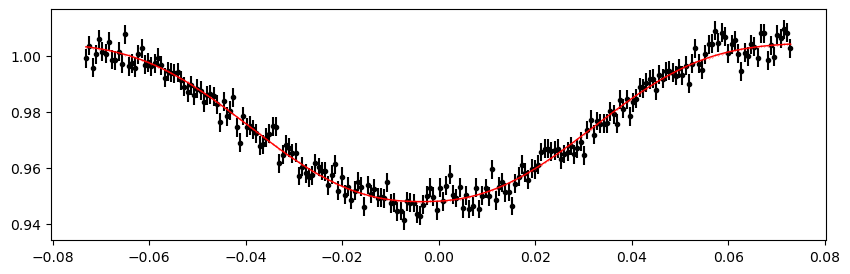

2829.8225599999996 1.01116069933887 -0.05374889050040259 -0.2733870719767836


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 321.67it/s]


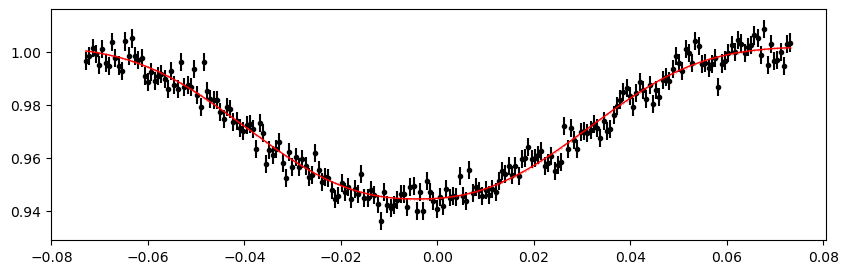

2831.867766 1.01116069933887 -0.05374889050040259 -0.2733870719767836


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 400.92it/s]


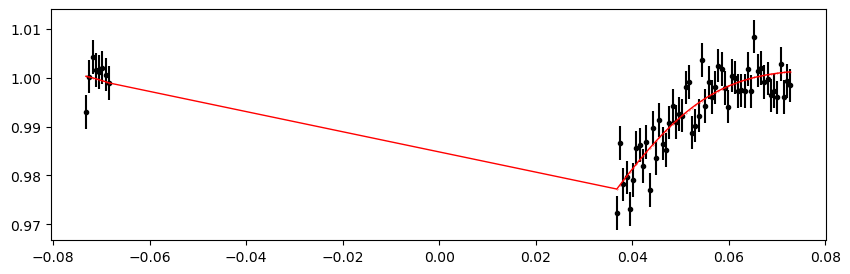

2833.912972 1.01116069933887 -0.05374889050040259 -0.2733870719767836


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 319.68it/s]


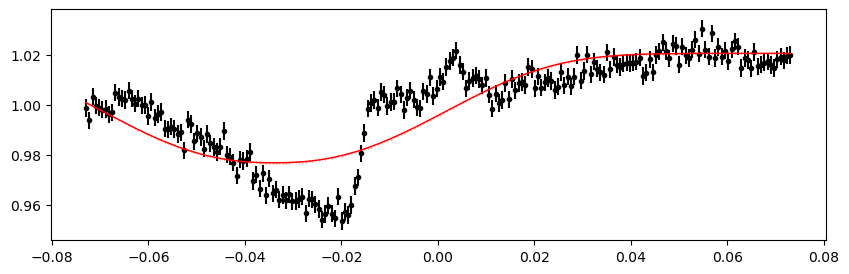

2835.958178 1.01116069933887 -0.05374889050040259 -0.2733870719767836


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 321.57it/s]


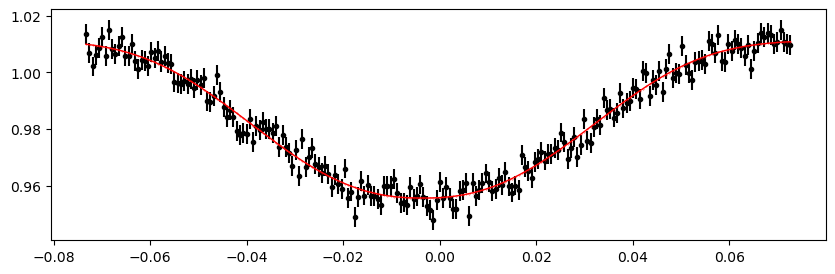

2838.0033839999996 1.01116069933887 -0.05374889050040259 -0.2733870719767836


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 324.61it/s]


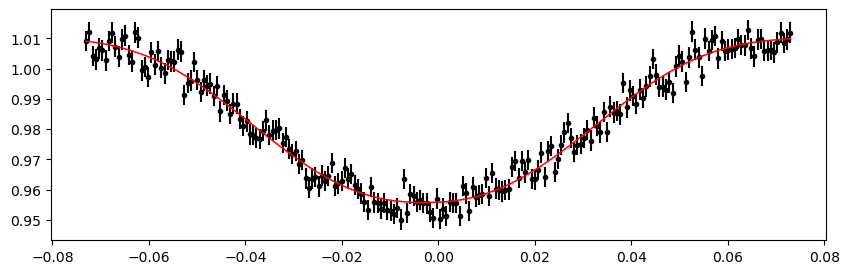

2840.04859 1.01116069933887 -0.05374889050040259 -0.2733870719767836


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 323.32it/s]


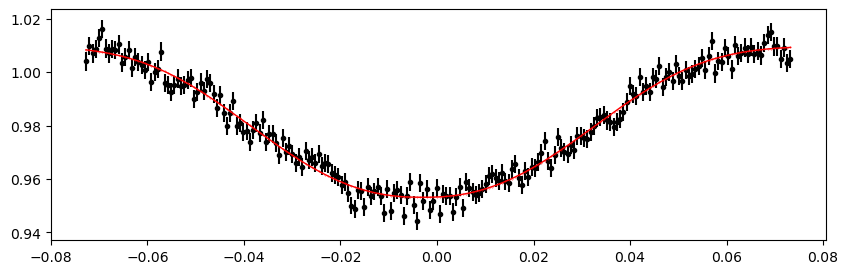

2842.093796 1.01116069933887 -0.05374889050040259 -0.2733870719767836


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 324.29it/s]


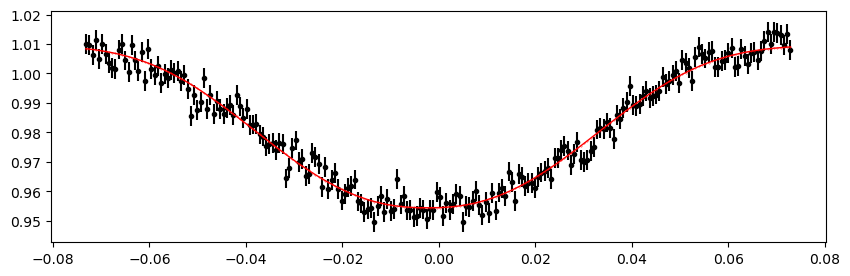

2844.139002 1.01116069933887 -0.05374889050040259 -0.2733870719767836


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 323.96it/s]


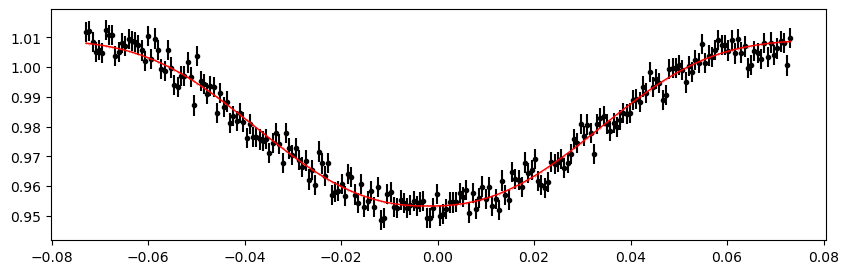

2846.1842079999997 1.01116069933887 -0.05374889050040259 -0.2733870719767836


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 337.94it/s]


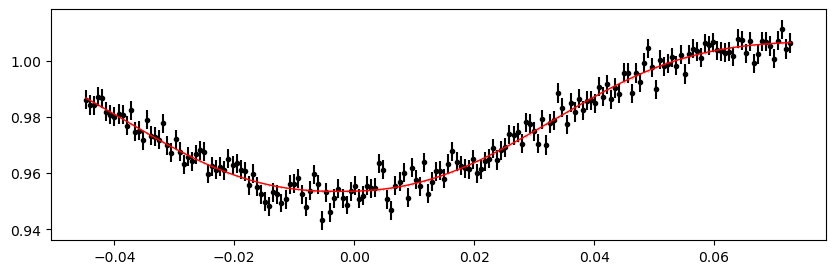

2848.229414 1.01116069933887 -0.05374889050040259 -0.2733870719767836


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 323.82it/s]


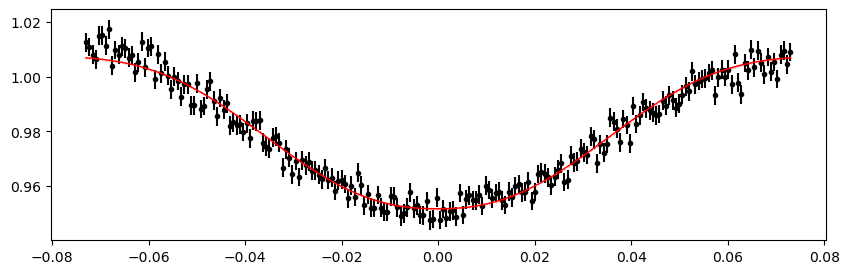

2850.27462 1.01116069933887 -0.05374889050040259 -0.2733870719767836


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 323.62it/s]


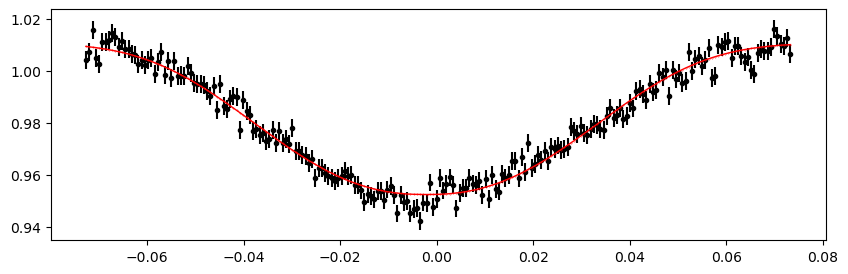

In [90]:
# Part 2

%matplotlib inline

# from importlib import reload
# reload(etv_functions)

print("Fitting individual primary eclipses...")
# use n_transits for _p2 so that the indexing (the column `number` in the output csv) is consistent with p1
outfile_path_p2 = outfile_path.replace(".csv", "_p2.csv")
etv_functions.fit_each_eclipse(data_primary_p2, n_transits, t0_primary, period, mean_alpha0_p2, mean_alpha1_p2, mean_t0_p2, mean_d_p2, mean_Tau_p2, outfile_path_p2,
                               min_number_data=20, 
                              )
!$NOTIFY_CMD "Individual primary eclipses (_p2) fit done"

# ---

%matplotlib inline

if t0_secondary is not None:
    print("Fitting individual secondary eclipses...")
    outfile_path_s_p2 = outfile_path_s.replace(".csv", "_p2.csv")
    etv_functions.fit_each_eclipse(data_secondary_p2, n_transits, t0_secondary, period, mean_alpha0_s_p2, mean_alpha1_s_p2, mean_t0_s_p2, mean_d_s_p2, mean_Tau_s_p2, outfile_path_s_p2,
                                   min_number_data=20, 
                                  )
    !$NOTIFY_CMD "Individual secondary eclipses ((_p2) fit done"
else:
    print("No secondary eclipses defined. No-Op.")

Fitting individual secondary eclipses...
Creating new manifest file
2420.78136 1.01116069933887 -0.05374889050040259 -0.2733870719767836


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 315.94it/s]


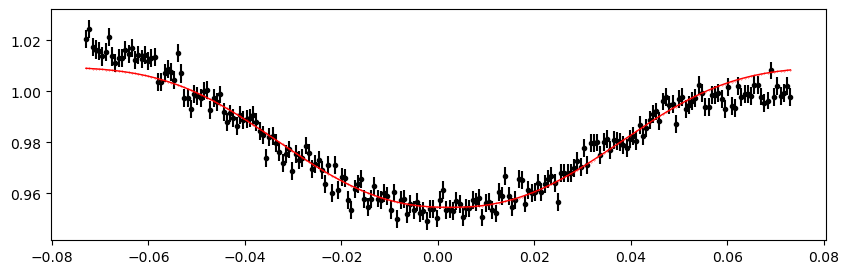

2422.8265659999997 1.01116069933887 -0.05374889050040259 -0.2733870719767836


100%|███████████████████████████████████████████████████████| 10000/10000 [00:34<00:00, 291.36it/s]


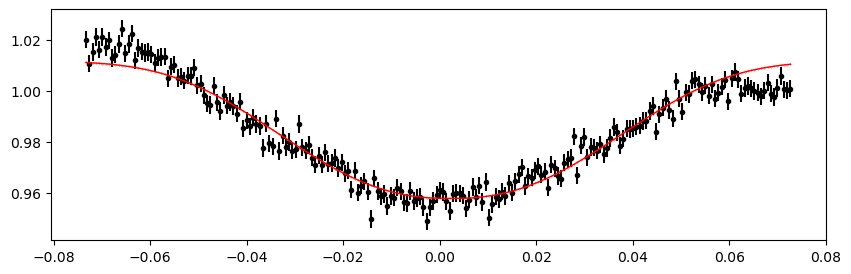

2424.871772 1.01116069933887 -0.05374889050040259 -0.2733870719767836


 51%|████████████████████████████▎                           | 5052/10000 [00:15<00:15, 317.80it/s]Traceback (most recent call last):
  File "C:\pkg\_winNonPortables\miniforge3\envs\my_lk_plus\lib\site-packages\emcee\ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "C:\dev\_juypter\PH_TESS_LightCurveViewer\eb_with_diff_sb_period\etv\etv_functions.py", line 535, in log_probability_fitting
    lnp = lp + log_likelihood_fitting(theta, x, y, yerr, mean_d, mean_Tau)
  File "C:\dev\_juypter\PH_TESS_LightCurveViewer\eb_with_diff_sb_period\etv\etv_functions.py", line 526, in log_likelihood_fitting
    return -0.5 * np.sum((y - model) ** 2 / (yerr**2))
  File "C:\pkg\_winNonPortables\miniforge3\envs\my_lk_plus\lib\site-packages\numpy\core\fromnumeric.py", line 2172, in _sum_dispatcher
    def _sum_dispatcher(a, axis=None, dtype=None, out=None, keepdims=None,
KeyboardInterrupt
 51%|████████████████████████████▎                           | 5060/10000 [00:

emcee: Exception while calling your likelihood function:
  params: [ 1.01014415 -0.05548134  0.00271192]
  args: (array([-0.07298394, -0.07230484, -0.07162573, -0.07094663, -0.07026753,
       -0.06958843, -0.06890933, -0.06823023, -0.06755113, -0.06687202,
       -0.06619292, -0.06551382, -0.06483472, -0.06415562, -0.06347652,
       -0.06279742, -0.06211832, -0.06143921, -0.06076011, -0.06008101,
       -0.05940191, -0.05872281, -0.05804371, -0.05736461, -0.0566855 ,
       -0.0560064 , -0.0553273 , -0.0546482 , -0.0539691 , -0.05329   ,
       -0.0526109 , -0.05193179, -0.05125269, -0.05057359, -0.04989449,
       -0.04921539, -0.04853629, -0.04785719, -0.04717808, -0.04649898,
       -0.04581988, -0.04514078, -0.04446168, -0.04378258, -0.04310348,
       -0.04242437, -0.04174527, -0.04106617, -0.04038707, -0.03970797,
       -0.03902887, -0.03834977, -0.03767067, -0.03699156, -0.03631246,
       -0.03563336, -0.03495426, -0.03427516, -0.03359606, -0.03291696,
       -0.03223785, -0

KeyboardInterrupt: 

In [97]:
# Combine part1 and part2 results together

pd.concat([pd.read_csv(outfile_path_p1), pd.read_csv(outfile_path_p2)]).to_csv(outfile_path, index=False)
pd.concat([pd.read_csv(outfile_path_s_p1), pd.read_csv(outfile_path_s_p2)]).to_csv(outfile_path_s, index=False)

## ETV O-C plot

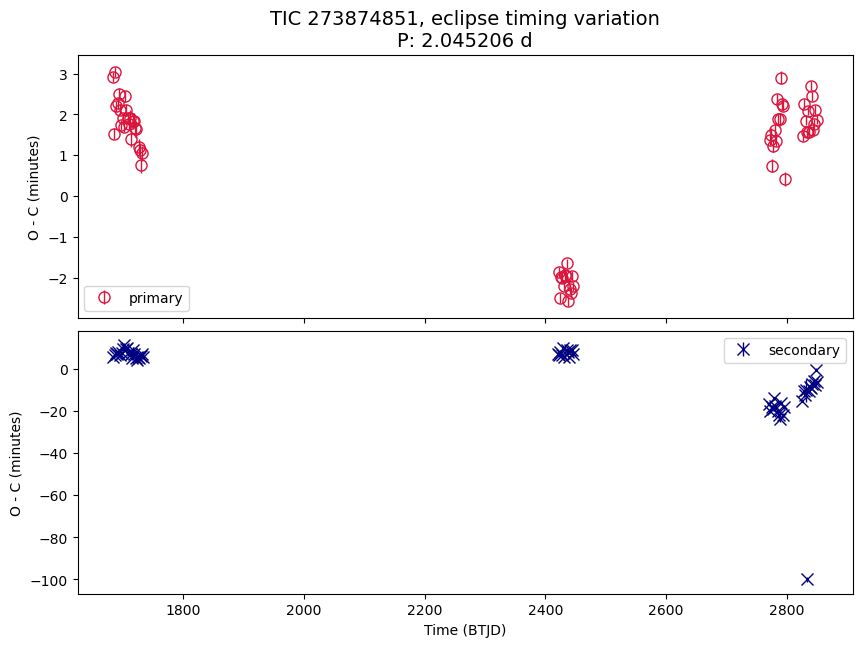

In [98]:
%matplotlib inline
# %matplotlib widget

#plot the extracted transit times to check for ETVs

num_rows = 2 if t0_secondary is not None else 1
figsize_y = 3.3 if num_rows == 1 else num_rows * 3.5
# num_rows = 1  # force to plot primary only
# figsize_y = 3.3

fig, axs = plt.subplots(num_rows, 1, figsize=(10, figsize_y), sharex=True)
if isinstance(axs, plt.Axes):  # handle edge case that num_rows == 1, returned axs is not a list
    axs = [axs]

in_df_primary = pd.read_csv(outfile_path)
in_df_primary['midpoint'] = in_df_primary['epoch'] + (in_df_primary['t0']*period)
in_df_primary['shift_mins'] = in_df_primary['t0']*period*24*60
in_df_primary['std_mins'] = in_df_primary['stdv_t0']*period*24*60

# axs[0].plot(in_df_primary['epoch'], in_df_primary['shift_mins'], 
#              lw = 1, color = 'crimson', )
# axs[0].scatter(in_df_primary['epoch'], in_df_primary['shift_mins'], 
#              marker = 'o', s=8**2, color = 'None', edgecolor = 'crimson', label="primary")
axs[0].errorbar(in_df_primary['epoch'], in_df_primary['shift_mins'], yerr = in_df_primary['std_mins'], 
             lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color = 'None', ecolor='crimson', markeredgecolor = 'crimson', label="primary")

# if False:
if t0_secondary is not None:
    in_df_secondary = pd.read_csv(outfile_path_s)
    in_df_secondary['midpoint'] = in_df_secondary['epoch'] + (in_df_secondary['t0']*period)
    in_df_secondary['shift_mins'] = in_df_secondary['t0']*period*24*60
    in_df_secondary['std_mins'] = in_df_secondary['stdv_t0']*period*24*60
    # axs[1].plot(in_df_secondary['epoch'], in_df_secondary['shift_mins'],
    #              lw = 1, color = 'navy', )
    # axs[1].scatter(in_df_secondary['epoch'], in_df_secondary['shift_mins'],
    #              marker = 'x',  s=9**2, color = 'navy', zorder = -2, label="secondary" );
    axs[1].errorbar(in_df_secondary['epoch'], in_df_secondary['shift_mins'], yerr = in_df_secondary['std_mins'], 
                 lw = 0, marker = 'x', elinewidth = 1, markersize = 9, color = 'navy', zorder = -2, label="secondary" );
else:
    in_df_secondary = None

for ax in axs:
    ax.set_ylabel("O - C (minutes)")
    ax.legend();

axs[-1].set_xlabel(f"Time ({search_result.time.format.upper()})")
axs[0].set_title(f"TIC {ticid}, eclipse timing variation\nP: {period} d", fontsize=14)

plt.subplots_adjust(hspace=0.05)
# plt.ylim(-3, 8)
plt.show()

### O-C Plot, Zoom In

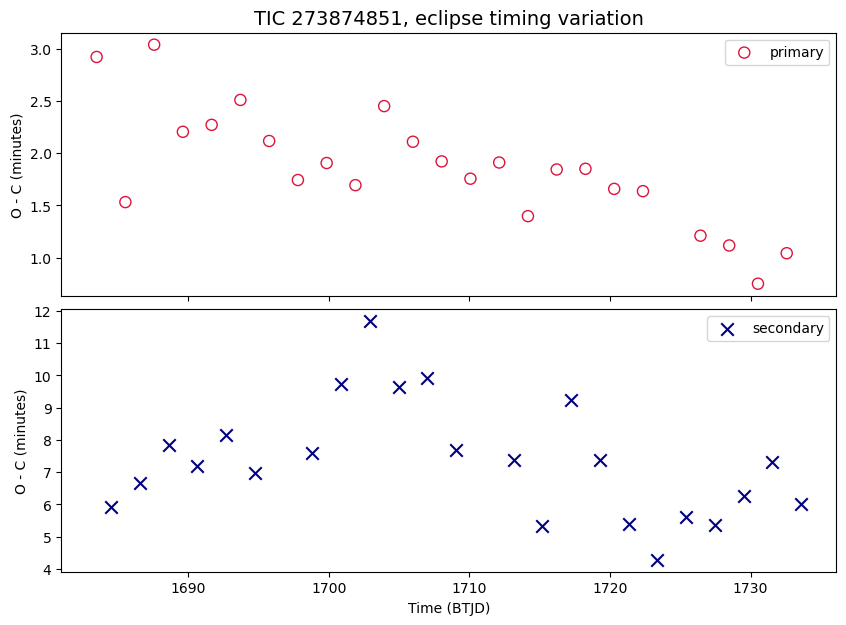

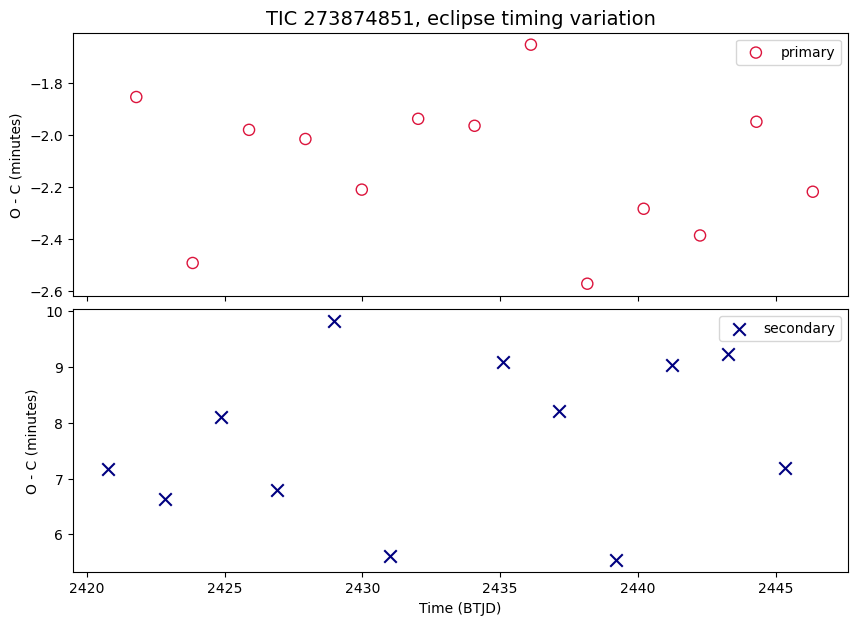

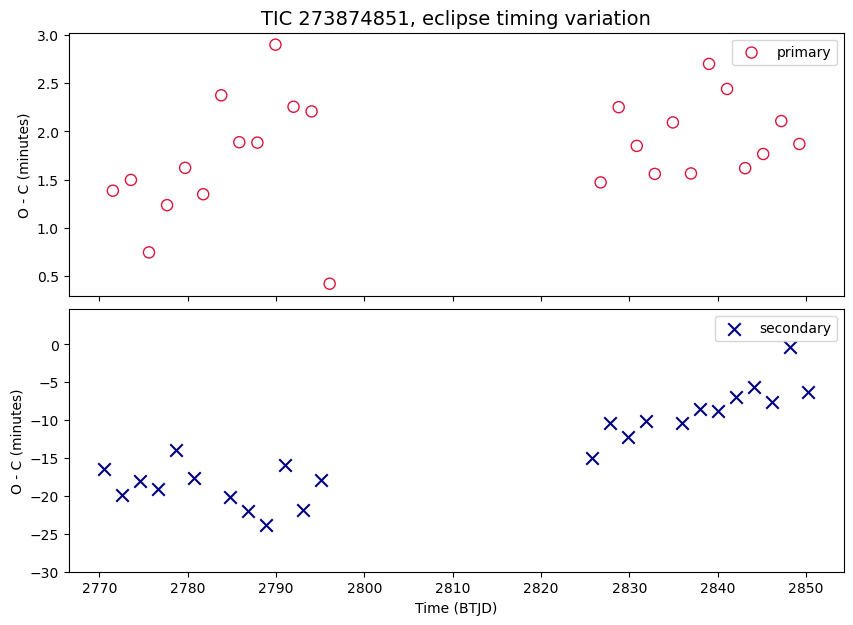

In [101]:
%matplotlib inline
# %matplotlib widget

zoom_ranges = [
    (1600, 1800),
    (2400, 2500),
    (2700, 2900),
]
title_suffix = "eclipse timing variation"

def tweak_axs_list(axs_list):
    # axs_list[0][1].set_ylim(-20, 30);
    # axs_list[1][0].set_ylim(None, 0.5);
    axs_list[2][1].set_ylim(-30, None);

    # ax = axs_list[0][0]
    # ax.set_title(f"{ax.get_title()} (2min cadence)")
    # ax = axs_list[1][0]
    # ax.set_title(f"{ax.get_title()} (2min cadence)")
    
    pass


def plot_oc_in_zoom_ranges(in_df_primary, in_df_secondary, zoom_ranges):
    axs_list = []
    for zoom_start, zoom_end in zoom_ranges:
        num_rows = 2 if t0_secondary is not None else 1
        figsize_y = 3.3 if num_rows == 1 else num_rows * 3.5
    
        fig, axs = plt.subplots(num_rows, 1, figsize=(10, figsize_y), sharex=True)
        if isinstance(axs, plt.Axes):  # handle edge case that num_rows == 1, returned axs is not a list
            axs = [axs]
        
        df_zoom = in_df_primary[(in_df_primary['epoch'] > zoom_start) & (in_df_primary['epoch'] < zoom_end)]
              
        axs[0].scatter(df_zoom['epoch'], df_zoom['shift_mins'], 
                       marker = 'o', s=8**2, color = 'None', edgecolor = 'crimson', label="primary")
        # axs[0].errorbar(df_zoom['epoch'], df_zoom['shift_mins'], yerr = df_zoom['std_mins'], 
        #                 lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color = 'None', ecolor='crimson', markeredgecolor = 'crimson', label="primary")
        
        if in_df_secondary is not None:
            df_zoom = in_df_secondary[(in_df_secondary['epoch'] > zoom_start) & (in_df_secondary['epoch'] < zoom_end)]
        
            axs[1].scatter(df_zoom['epoch'], df_zoom['shift_mins'],
                           marker = 'x',  s=9**2, color = 'navy', zorder = -2, label="secondary" );
            # axs[1].errorbar(df_zoom['epoch'], df_zoom['shift_mins'], yerr = df_zoom['std_mins'],
            #                 lw = 0, marker = 'x', elinewidth = 1, markersize = 9, color = 'navy', zorder = -2, label="secondary" );
        
        for ax in axs:
            ax.set_ylabel("O - C (minutes)")
            ax.legend();
        
        axs[-1].set_xlabel("Time (BTJD)")
        axs[0].set_title(f"TIC {ticid}, {title_suffix}", fontsize=14)
        
        plt.subplots_adjust(hspace=0.05)
        axs_list.append(axs)
    return axs_list


axs_list = plot_oc_in_zoom_ranges(in_df_primary, in_df_secondary, zoom_ranges)
tweak_axs_list(axs_list);

## make a periodogram 

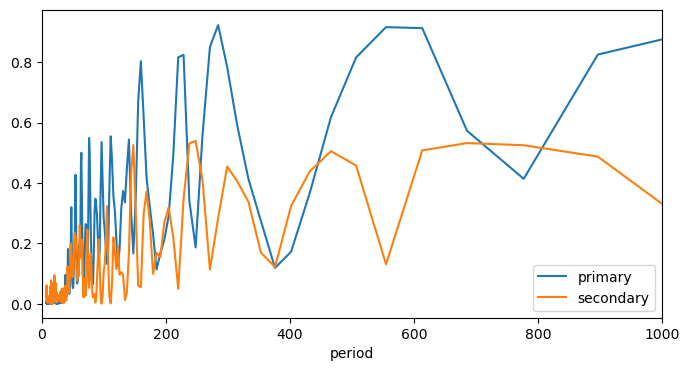

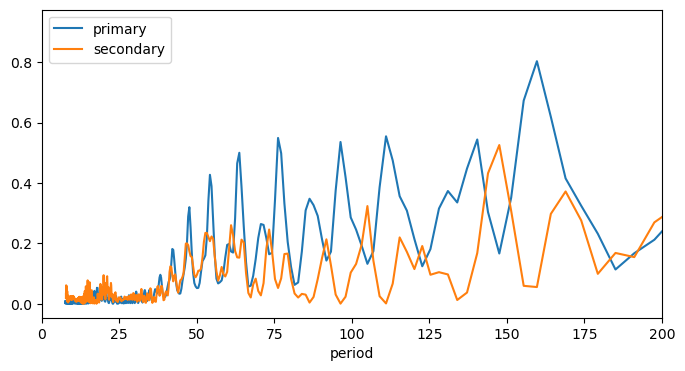

In [103]:
frequency, power = LombScargle(in_df_primary['epoch'], in_df_primary['shift_mins']).autopower()

fig, ax = plt.subplots(figsize=(8, 4))

plt.plot(1/frequency, power, label = 'primary')    

if t0_secondary is not None:
    frequency_s, power_s = LombScargle(in_df_secondary['epoch'], in_df_secondary['shift_mins']).autopower()
    plt.plot(1/frequency_s, power_s, label = 'secondary')    

plt.xlabel("period")

plt.legend()
plt.xlim(0, 1000)
plt.show()


if True:
    fig, ax = plt.subplots(figsize=(8, 4))
    
    plt.plot(1/frequency, power, label = 'primary')    
    
    if t0_secondary is not None:
        frequency_s, power_s = LombScargle(in_df_secondary['epoch'], in_df_secondary['shift_mins']).autopower()
        plt.plot(1/frequency_s, power_s, label = 'secondary')    
    
    plt.xlabel("period")
    
    plt.legend()
    plt.xlim(0, 200)
    plt.show()

## Results Summary

In [112]:
# FILL-IN the ETV results / comments
has_etv = "Y?"
comments = "O-C suggests some variation that might be a trend. Eclipses signficantly shallower afer a long gap, around BTJD 2400, possibly due to contamination of nearby TIC 1881902473 (<1 arcsec away, delta mag +0.7)."

# Eclipse depth from the model
depth_pct_p = round(-mean_alpha1_p1 * 100, 2)
if t0_secondary is not None:
    depth_pct_s = round(-mean_alpha1_s_p1 * 100, 2)
else:
    depth_pct_s = None

summary = {
    "tic": ticid,
    "has_etv": has_etv,
    "comments": comments,
    "period": period,  # the period used in ETV analysis
    "depth_pct_p": depth_pct_p,
    "depth_pct_s": depth_pct_s,
    "epoch_p": t0_primary,
    "epoch_s": t0_secondary,
    "num_sectors": len(sr),
    "time_span": round(time[-1] - time[0], 2),
    "time_start": round(time[0], 2),
    "time_end": round(time[-1], 2),
}

summary = pd.DataFrame.from_dict(summary, orient="index")
with pd.option_context('display.max_colwidth', None, 'display.max_rows', 999, 'display.max_columns', 99):
    display(summary);

# Single line to be added to a CSV
print("")
print(summary.transpose().to_csv(
    index=False,
    header=True, 
))

0
tic                                                                                                                                                                                                               273874851
has_etv                                                                                                                                                                                                                  Y?
comments     O-C suggests some variation that might be a trend. Eclipses signficantly shallower afer a long gap, around BTJD 2400, possibly due to contamination of nearby TIC 1881902473 (<1 arcsec away, delta mag +0.7).
period                                                                                                                                                                                                             2.045206
depth_pct_p                                                                                                                                                                                                           59.91
depth_pct_s                                                                                                                                                                                                           10.73
epoch_p                                                                                                                                                                                                           1683.4792
epoch_s                                                                                                                                                                                                           1684.5072
num_sectors                                                                                                                                                                                                               5
time_span                                                                                                                                                                                                           1169.78
time_start                                                                                                                                                                                                          1683.36
time_end                                                                                                                                                                                                            2853.14


tic,has_etv,comments,period,depth_pct_p,depth_pct_s,epoch_p,epoch_s,num_sectors,time_span,time_start,time_end
273874851,Y?,"O-C suggests some variation that might be a trend. Eclipses signficantly shallower afer a long gap, around BTJD 2400, possibly due to contamination of nearby TIC 1881902473 (<1 arcsec away, delta mag +0.7).",2.045206,59.91,10.73,1683.4792,1684.5072,5,1169.78,1683.36,2853.14

